### Get Test Data Only
We are going to evaluate the models using the `etaylor_cannabis_patches_test_26-04-2024_15-44-44` test dataset.

In [4]:
import numpy as np

def convert_ndarrays_to_lists(obj):
    if isinstance(obj, dict):
        return {k: convert_ndarrays_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays_to_lists(elem) for elem in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, float)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64, int)):
        return int(obj)
    else:
        return obj


### Evaluation Methods
We are going to use `BaseEvaluator` class for evaluating the models, which will perform classification. 


In [5]:
import os

dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44"
images_dir_path = os.path.join(dataset_path, "v0.1")
coco_annotations_path = os.path.join(dataset_path, "annotations", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json")
yolo_annotations_dir_path = os.path.join(dataset_path, "annotations", "yolo", "labels", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1")


### Evaluating the Detectron2 models

In [6]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [9]:
# add /sise/home/etaylor/code_projects/thesis to sys path
import sys
sys.path.append("/home/etaylor/code_projects/thesis")

In [10]:
from src.segmentation.evaluation.detectron2_evaluator import Detectron2Evaluator

detectron2_evaluator = Detectron2Evaluator(num_classes=3,coco_annotations_file_path=coco_annotations_path)

dataset_gt_boxes = detectron2_evaluator.get_annotations_for_dataset(images_directory=images_dir_path)

In [4]:
# setup all the models configurations for that evaluation experiment
models_configs = [
    {
        "model_name": "mask_rcnn_R_50_FPN_3x",
        "checkpoint": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/model_final.pth",
        "yaml_file": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/config.yaml"
    },
    {
        "model_name": "mask_rcnn_X_101_32x8d_FPN_3x",
        "checkpoint": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/27-04-2024_13-54-23/model_final.pth",
        "yaml_file": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/27-04-2024_13-54-23/config.yaml"
    },
    {
        "model_name": "faster_rcnn_R_50_C4_1x",
        "checkpoint": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/29-04-2024_16-09-41/model_final.pth",
        "yaml_file": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/29-04-2024_16-09-41/config.yaml"
    },
    {
        "model_name": "faster_rcnn_R_50_DC5_1x",
        "checkpoint": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_1x/29-04-2024_16-09-55/model_final.pth",
        "yaml_file": "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_1x/29-04-2024_16-09-55/config.yaml"
    },
]

In [5]:
import time
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

models_pred_boxes = {}
models_preds = {}
models_prediction_times = {}  # Dictionary to store prediction times

for model_config in models_configs:
    
    cfg = get_cfg()
    # load config
    cfg.merge_from_file(model_config['yaml_file'])
    
    # load checkpoint
    cfg.MODEL.WEIGHTS = model_config['checkpoint']
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    
    # define predictor
    predictor = DefaultPredictor(cfg)
    
    print(f"Predicting with model: {model_config['model_name']}")
    
    # Measure prediction time
    start_time = time.time()
    
    # get predictions as bounding boxes
    dataset_pred_boxes = detectron2_evaluator.predict_and_parse_dataset(images_directory=images_dir_path, predictor=predictor)
    
    # Calculate the prediction time
    prediction_time = time.time() - start_time
    
    # Save the prediction time
    models_prediction_times[model_config['model_name']] = prediction_time
    
    # save the models pred boxes
    models_pred_boxes[model_config['model_name']] = dataset_pred_boxes
    
    # evaluate the predictions on the gt boxes
    eval_results = detectron2_evaluator.evaluate_dataset(dataset_gt_boxes_dict=dataset_gt_boxes,
                                                        dataset_pred_boxes_dict=dataset_pred_boxes)
    
    models_preds[model_config['model_name']] = eval_results
    
    print(f"Model: {model_config['model_name']} - Prediction Time: {prediction_time:.2f} seconds")

Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[05/24 14:36:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/29-04-2024_16-02-00/model_final.pth ...
Predicting with model: mask_rcnn_R_50_FPN_3x


/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/27-04-2024_13-54-23/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


Model: mask_rcnn_R_50_FPN_3x - Prediction Time: 5.18 seconds
[05/24 14:36:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/27-04-2024_13-54-23/model_final.pth ...
Predicting with model: mask_rcnn_X_101_32x8d_FPN_3x


Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/29-04-2024_16-09-41/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


Model: mask_rcnn_X_101_32x8d_FPN_3x - Prediction Time: 8.37 seconds
[05/24 14:37:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/29-04-2024_16-09-41/model_final.pth ...
Predicting with model: faster_rcnn_R_50_C4_1x


Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_1x/29-04-2024_16-09-55/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


Model: faster_rcnn_R_50_C4_1x - Prediction Time: 11.18 seconds
[05/24 14:37:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_1x/29-04-2024_16-09-55/model_final.pth ...
Predicting with model: faster_rcnn_R_50_DC5_1x
Model: faster_rcnn_R_50_DC5_1x - Prediction Time: 6.19 seconds


In [8]:
# save the model predictions results
import json

# Convert all numpy arrays to lists in the dictionary   
detectron2_models_pred_boxes = convert_ndarrays_to_lists(models_pred_boxes)

# save models scores
detectron2_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "detectron2_models_pred_boxes_result_22_05_2024.json")


with open(detectron2_models_pred_boxes_saveing_path, "w") as f:
    json.dump(detectron2_models_pred_boxes, f, indent=4)
    
print("Models scores saved to: ", detectron2_models_pred_boxes_saveing_path)

Models scores saved to:  /home/etaylor/code_projects/thesis/data/models_scores/detectron2_models_pred_boxes_result_22_05_2024.json


In [6]:
models_preds

{'mask_rcnn_R_50_FPN_3x': {'metrics': {'precision': 0.6297043010752689,
   'recall': 0.6144262295081967,
   'class_wise_precision': array([0.63586957, 0.6267672 , 0.6440678 ]),
   'class_wise_recall': array([0.42622951, 0.77146172, 0.33333333])},
  'confusion_matrix': array([[234, 191,   1, 123],
         [ 60, 665,   7, 130],
         [  2,  12,  38,  62],
         [ 72, 193,  13,   0]]),
  'normalized_confusion_matrix': array([[0.4262295 , 0.34790528, 0.00182149, 0.22404371],
         [0.06960557, 0.7714617 , 0.00812065, 0.15081206],
         [0.01754386, 0.10526316, 0.33333334, 0.54385966],
         [0.2589928 , 0.6942446 , 0.04676259, 0.        ]], dtype=float32)},
 'mask_rcnn_X_101_32x8d_FPN_3x': {'metrics': {'precision': 0.6681190994916485,
   'recall': 0.6032786885245902,
   'class_wise_precision': array([0.66004963, 0.67066521, 0.68421053]),
   'class_wise_recall': array([0.4845173 , 0.71345708, 0.34210526])},
  'confusion_matrix': array([[266, 138,   2, 143],
         [ 79, 61

In [8]:
# Convert all numpy arrays to lists in the dictionary
models_preds = convert_ndarrays_to_lists(models_preds)

In [9]:
# save models scores
import json
detectron2_models_results_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "detectron2_models_evaluator_result_22_05_2024.json")
with open(detectron2_models_results_saveing_path, "w") as f:
    json.dump(models_preds, f, indent=4)
    
print("Models scores saved to: ", os.path.join(dataset_path, "annotations", "models_scores.json"))

Models scores saved to:  /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/models_scores.json


### Evaluating the Ultralytics Models

In [9]:
import os

dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44"
images_dir_path = os.path.join(dataset_path, "v0.1")
coco_annotations_path = os.path.join(dataset_path, "annotations", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json")
yolo_annotations_dir_path = os.path.join(dataset_path, "annotations", "yolo", "labels", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1")


In [10]:
from src.segmentation.evaluation.ultralytics_evaluator import UltralyticsEvaluator

ultralytics_evaluator = UltralyticsEvaluator(num_classes=3, image_size=512)

dataset_gt_boxes = ultralytics_evaluator.get_annotations_for_dataset(annotations_directory=yolo_annotations_dir_path)

In [11]:
# setup models configs
ultralytics_models_configs = [
    {
        "model_name": "rtdetr_x",
        "checkpoint": "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train14/weights/best.pt"
    },
    {
        "model_name": "yolov5xu",
        "checkpoint": "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train17/weights/best.pt"
    },
    {
        "model_name": "yolov8x",
        "checkpoint": "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train16/weights/best.pt"
    },
    {
        "model_name": "yolov9c",
        "checkpoint": "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train12/weights/best.pt"
    }
]

In [13]:
import time
from ultralytics import RTDETR, YOLO

ultralytics_models_scores = {}
models_pred_boxes = {}
models_prediction_times = {}  # Dictionary to store prediction times

for model_config in ultralytics_models_configs:
    
    if model_config['model_name'] == "rtdetr_x":
        predictor = RTDETR(model_config['checkpoint'])
    else:
        predictor = YOLO(model_config['checkpoint'])
        
    print(f"Predicting with model: {model_config['model_name']}")
    
    # Measure prediction time
    start_time = time.time()
    
    # Predict the dataset and save results
    dataset_pred_boxes = ultralytics_evaluator.predict_and_parse_dataset(images_directory=images_dir_path, predictor=predictor)
    prediction_time = time.time() - start_time  # Calculate the prediction time
    
    # Save the prediction time
    models_prediction_times[model_config['model_name']] = prediction_time
    
    models_pred_boxes[model_config['model_name']] = dataset_pred_boxes
    
    # Evaluate the predictions on the gt boxes
    eval_results = ultralytics_evaluator.evaluate_dataset(dataset_gt_boxes_dict=dataset_gt_boxes,
                                                        dataset_pred_boxes_dict=dataset_pred_boxes)
    
    # Save the results
    ultralytics_models_scores[model_config['model_name']] = eval_results
    
    print(f"Model: {model_config['model_name']} - Prediction Time: {prediction_time:.2f} seconds")


Predicting with model: rtdetr_x

image 1/1 /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1/IMG_1093_p0.png: 512x512 4 trichomes, 21 clears, 5 cloudys, 65.3ms
Speed: 0.7ms preprocess, 65.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1/IMG_1093_p10.png: 512x512 6 trichomes, 10 clears, 59.4ms
Speed: 0.7ms preprocess, 59.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1/IMG_1093_p11.png: 512x512 4 trichomes, 12 clears, 2 cloudys, 60.8ms
Speed: 0.7ms preprocess, 60.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1/IMG_1093_p2.png: 512x512 3 trichomes, 3 clear

In [23]:
# save the model predictions results
import json

# Convert all numpy arrays to lists in the dictionary   
ultralytics_models_pred_boxes = convert_ndarrays_to_lists(models_pred_boxes)

# save models scores
ultralytics_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "ultralytics_models_pred_boxes_result_22_05_2024.json")


with open(ultralytics_models_pred_boxes_saveing_path, "w") as f:
    json.dump(ultralytics_models_pred_boxes, f, indent=4)
    
print("Models scores saved to: ", ultralytics_models_pred_boxes_saveing_path)

Models scores saved to:  /home/etaylor/code_projects/thesis/data/models_scores/ultralytics_models_pred_boxes_result_22_05_2024.json


In [24]:
# save evaluation results
ultralytics_models_scores = convert_ndarrays_to_lists(ultralytics_models_scores)

ultralytics_models_results_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "ultralytics_models_evaluator_result_22_05_2024.json")

with open(ultralytics_models_results_saveing_path, "w") as f:
    json.dump(ultralytics_models_scores, f, indent=4)
    
print("Models scores saved to: ", ultralytics_models_results_saveing_path)


Models scores saved to:  /home/etaylor/code_projects/thesis/data/models_scores/ultralytics_models_evaluator_result_22_05_2024.json


### Evaluate with Yolo-Nas

In [1]:
import os

dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44"
images_dir_path = os.path.join(dataset_path, "v0.1")
coco_annotations_path = os.path.join(dataset_path, "annotations", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json")
yolo_annotations_dir_path = os.path.join(dataset_path, "annotations", "yolo", "labels", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1")


In [2]:
from src.segmentation.evaluation.yolo_nas_evaluator import YoloNasEvaluator

evaluator = YoloNasEvaluator(num_classes=3, image_size=512)

dataset_gt_boxes = evaluator.get_annotations_for_dataset(annotations_directory=yolo_annotations_dir_path)

In [3]:
from super_gradients.training import models

predictor = models.get('yolo_nas_l',
                        num_classes=4,
                        checkpoint_path="/home/etaylor/code_projects/thesis/checkpoints/yolo_nas/my_first_yolonas_run/RUN_20240504_142004_922632/ckpt_latest.pth")

The console stream is logged into /home/etaylor/sg_logs/console.log


[2024-05-25 23:07:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-05-25 23:07:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/my_first_yolonas_run/RUN_20240504_142004_922632/ckpt_latest.pth EMA checkpoint.


In [4]:
yolo_nas_results = evaluator.predict_and_parse_dataset(predictor=predictor, images_directory=images_dir_path)

Processing patch: IMG_1096_p10.png


Processing patch: IMG_1096_p11.png
Processing patch: IMG_1096_p1.png
Processing patch: IMG_1096_p12.png
Processing patch: IMG_1096_p3.png
Processing patch: IMG_1096_p4.png
Processing patch: IMG_1096_p8.png
Processing patch: IMG_1096_p6.png
Processing patch: IMG_1096_p0.png
Processing patch: IMG_1096_p7.png
Processing patch: IMG_1096_p9.png
Processing patch: IMG_0019_p0.png
Processing patch: IMG_0019_p1.png
Processing patch: IMG_0019_p10.png
Processing patch: IMG_0019_p2.png
Processing patch: IMG_0019_p3.png
Processing patch: IMG_0019_p4.png
Processing patch: IMG_0019_p6.png
Processing patch: IMG_0019_p5.png
Processing patch: IMG_0019_p7.png
Processing patch: IMG_0019_p9.png
Processing patch: IMG_0019_p8.png
Processing patch: IMG_2285_p0.png
Processing patch: IMG_2285_p11.png
Processing patch: IMG_2285_p12.png
Processing patch: IMG_2285_p13.png
Processing patch: IMG_2285_p1.png
Processing patch: IMG_2285_p2.png
Processing patch: IMG_2285_p3.png
Processing patch: IMG_2285_p5.png
Processi

In [5]:
# Evaluate the predictions on the gt boxes
yolo_nas_eval_results = evaluator.evaluate_dataset(dataset_gt_boxes_dict=dataset_gt_boxes, dataset_pred_boxes_dict=yolo_nas_results)
yolo_nas_eval_results

{'metrics': {'precision': 0.4538087520259319,
  'recall': 0.5508196721311476,
  'class_wise_precision': array([0.58433735, 0.43963964, 0.55      ]),
  'class_wise_recall': array([0.17668488, 0.84918794, 0.09649123])},
 'confusion_matrix': array([[ 97, 328,   1, 123],
        [ 14, 732,   0, 116],
        [  2,  23,  11,  78],
        [ 53, 582,   8,   0]]),
 'normalized_confusion_matrix': array([[0.17668489, 0.5974499 , 0.00182149, 0.22404371],
        [0.0162413 , 0.8491879 , 0.        , 0.13457076],
        [0.01754386, 0.20175439, 0.09649123, 0.68421054],
        [0.08242613, 0.9051322 , 0.01244168, 0.        ]], dtype=float32)}

### Analyze Evaluator Results
In this section we will analyze with graphs the results received by evaluating all the models using the Evaluator

In [1]:
# laod the results jsons
import json
import os

detectron2_models_results_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "detectron2_models_evaluator_result_22_05_2024.json")
ultralytics_models_results_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "ultralytics_models_evaluator_result_22_05_2024.json")

with open(detectron2_models_results_saveing_path, "r") as f:
    detectron2_models_scores = json.load(f)
    
with open(ultralytics_models_results_saveing_path, "r") as f:
    ultralytics_models_scores = json.load(f)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_bar(models_results, metric_name, ylabel, iou_threshold):
    labels = list(models_results.keys())
    values = [results['metrics'][metric_name] for results in models_results.values()]
    
    if isinstance(values[0], list) or isinstance(values[0], np.ndarray):
        x = np.arange(len(labels))
        width = 0.2  # Width of the bars
        num_classes = len(values[0])
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(num_classes):
            class_values = [v[i] for v in values]
            ax.bar(x + i * width, class_values, width, label=f'Class {i+1}')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x + width * (num_classes - 1) / 2)
        ax.set_xticklabels(labels)
        plt.xticks(rotation=45)
    else:
        x = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x, values, width=0.5, color='blue')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        plt.xticks(rotation=45)
    
    ax.legend()
    plt.show()
    
def plot_confusion_matrix(models_results, normalized=True, iou_threshold=None):
    for model, results in models_results.items():
        if normalized:
            matrix = np.array(results['normalized_confusion_matrix'])
        else:
            matrix = np.array(results['confusion_matrix'])
        
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        title = f'Confusion Matrix for {model}'
        if iou_threshold is not None:
            title += f' (IoU={iou_threshold})'
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(matrix))
        plt.xticks(tick_marks, tick_marks, rotation=45)
        plt.yticks(tick_marks, tick_marks)
        
        fmt = '.2f' if normalized else 'd'
        thresh = matrix.max() / 2.
        for i, j in np.ndindex(matrix.shape):
            plt.text(j, i, format(matrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if matrix[i, j] > thresh else "black")
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()


In [3]:
def plot_evaluation_results(combined_results, iou_threshold):
    """
    Plots various metrics and confusion matrices from the combined evaluation results for a given IoU threshold.

    Args:
        combined_results (dict): Dictionary containing evaluation results for various models.
        iou_threshold (float): The IoU threshold used for the evaluation.
    """
    plot_metric_bar(combined_results, 'precision', 'Precision', iou_threshold)
    plot_metric_bar(combined_results, 'recall', 'Recall', iou_threshold)
    plot_metric_bar(combined_results, 'class_wise_precision', 'Class-wise Precision', iou_threshold)
    plot_metric_bar(combined_results, 'class_wise_recall', 'Class-wise Recall', iou_threshold)
    plot_confusion_matrix(combined_results, normalized=False, iou_threshold=iou_threshold)
    plot_confusion_matrix(combined_results, normalized=True, iou_threshold=iou_threshold)


## Evaluate and Plot Results for Different IoU Thresholds

In [1]:
# laod the pred boxes of each model
import json
import os
import numpy as np

# load the ultralytics models pred boxes
ultralytics_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "ultralytics_models_pred_boxes_result_22_05_2024.json")
detectron2_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "detectron2_models_pred_boxes_result_22_05_2024.json")

with open(ultralytics_models_pred_boxes_saveing_path, "r") as f:
    ultralytics_models_pred_boxes = json.load(f)
    
with open(detectron2_models_pred_boxes_saveing_path, "r") as f:
    detectron2_models_pred_boxes = json.load(f)

In [12]:
import numpy as np

iou_thresholds = np.arange(0.3, 1.0, 0.05)
results = {}

for iou_threshold in iou_thresholds:
    print(f"Evaluating models with IoU threshold: {np.round(iou_threshold,2)}")
    
    # Dictionary to store the results for the current IoU threshold
    iou_results = {}
    
    # Evaluate the Ultralytics models
    for model_name, model_pred_boxes in ultralytics_models_pred_boxes.items():
        ultra_eval_results = detectron2_evaluator.evaluate_dataset(
            dataset_gt_boxes_dict=dataset_gt_boxes,
            dataset_pred_boxes_dict=model_pred_boxes, 
            iou_thresh=iou_threshold
        )
        iou_results[model_name] = ultra_eval_results
        
    # Evaluate the Detectron2 models
    for model_name, model_pred_boxes in detectron2_models_pred_boxes.items():
        det_eval_results = detectron2_evaluator.evaluate_dataset(
            dataset_gt_boxes_dict=dataset_gt_boxes,
            dataset_pred_boxes_dict=model_pred_boxes, 
            iou_thresh=iou_threshold
        )
        iou_results[model_name] = det_eval_results
    
    # Combine results and save them in the results dictionary under the current IoU threshold
    results[iou_threshold] = iou_results


Evaluating models with IoU threshold: 0.3


Evaluating models with IoU threshold: 0.35
Evaluating models with IoU threshold: 0.4
Evaluating models with IoU threshold: 0.45
Evaluating models with IoU threshold: 0.5
Evaluating models with IoU threshold: 0.55
Evaluating models with IoU threshold: 0.6
Evaluating models with IoU threshold: 0.65
Evaluating models with IoU threshold: 0.7
Evaluating models with IoU threshold: 0.75
Evaluating models with IoU threshold: 0.8
Evaluating models with IoU threshold: 0.85
Evaluating models with IoU threshold: 0.9
Evaluating models with IoU threshold: 0.95


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_results(combined_results, iou_threshold):
    """
    Plots various metrics and confusion matrices from the combined evaluation results for a given IoU threshold.

    Args:
        combined_results (dict): Dictionary containing evaluation results for various models.
        iou_threshold (float): The IoU threshold used for the evaluation.
    """
    # Plotting bar metrics
    fig1, axes1 = plt.subplots(2, 2, figsize=(20, 12))
    fig1.suptitle(f'Evaluation Results for IoU Threshold {iou_threshold}', fontsize=16)

    plot_metric_bar(combined_results, 'precision', 'Precision', iou_threshold, ax=axes1[0, 0])
    plot_metric_bar(combined_results, 'recall', 'Recall', iou_threshold, ax=axes1[0, 1])
    plot_metric_bar(combined_results, 'class_wise_precision', 'Class-wise Precision', iou_threshold, ax=axes1[1, 0])
    plot_metric_bar(combined_results, 'class_wise_recall', 'Class-wise Recall', iou_threshold, ax=axes1[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting confusion matrices
    num_models = len(combined_results)
    fig2, axes2 = plt.subplots(2, num_models, figsize=(20, 12))
    fig2.suptitle(f'Confusion Matrices for IoU Threshold {iou_threshold}', fontsize=16)

    for idx, (model, results) in enumerate(combined_results.items()):
        plot_single_confusion_matrix(results, model, False, iou_threshold, ax=axes2[0, idx])
        plot_single_confusion_matrix(results, model, True, iou_threshold, ax=axes2[1, idx])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_metric_bar(models_results, metric_name, ylabel, iou_threshold, ax=None):
    labels = list(models_results.keys())
    values = [results['metrics'][metric_name] for results in models_results.values()]
    
    if isinstance(values[0], list) or isinstance(values[0], np.ndarray):
        x = np.arange(len(labels))
        width = 0.2  # Width of the bars
        num_classes = len(values[0])
        for i in range(num_classes):
            class_values = [v[i] for v in values]
            ax.bar(x + i * width, class_values, width, label=f'Class {i+1}')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x + width * (num_classes - 1) / 2)
        ax.set_xticklabels(labels)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    else:
        x = np.arange(len(labels))
        ax.bar(x, values, width=0.5, color='blue')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

def plot_single_confusion_matrix(results, model, normalized, iou_threshold, ax=None):
    if normalized:
        matrix = np.array(results['normalized_confusion_matrix'])
        title = model
        fmt = '.2f'
    else:
        matrix = np.array(results['confusion_matrix'])
        title = model
        fmt = 'd'

    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(matrix))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(tick_marks, rotation=45)
    ax.set_yticklabels(tick_marks)
    
    thresh = matrix.max() / 2.
    for i, j in np.ndindex(matrix.shape):
        ax.text(j, i, format(matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if matrix[i, j] > thresh else "black")
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


Results for IoU threshold: 0.3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


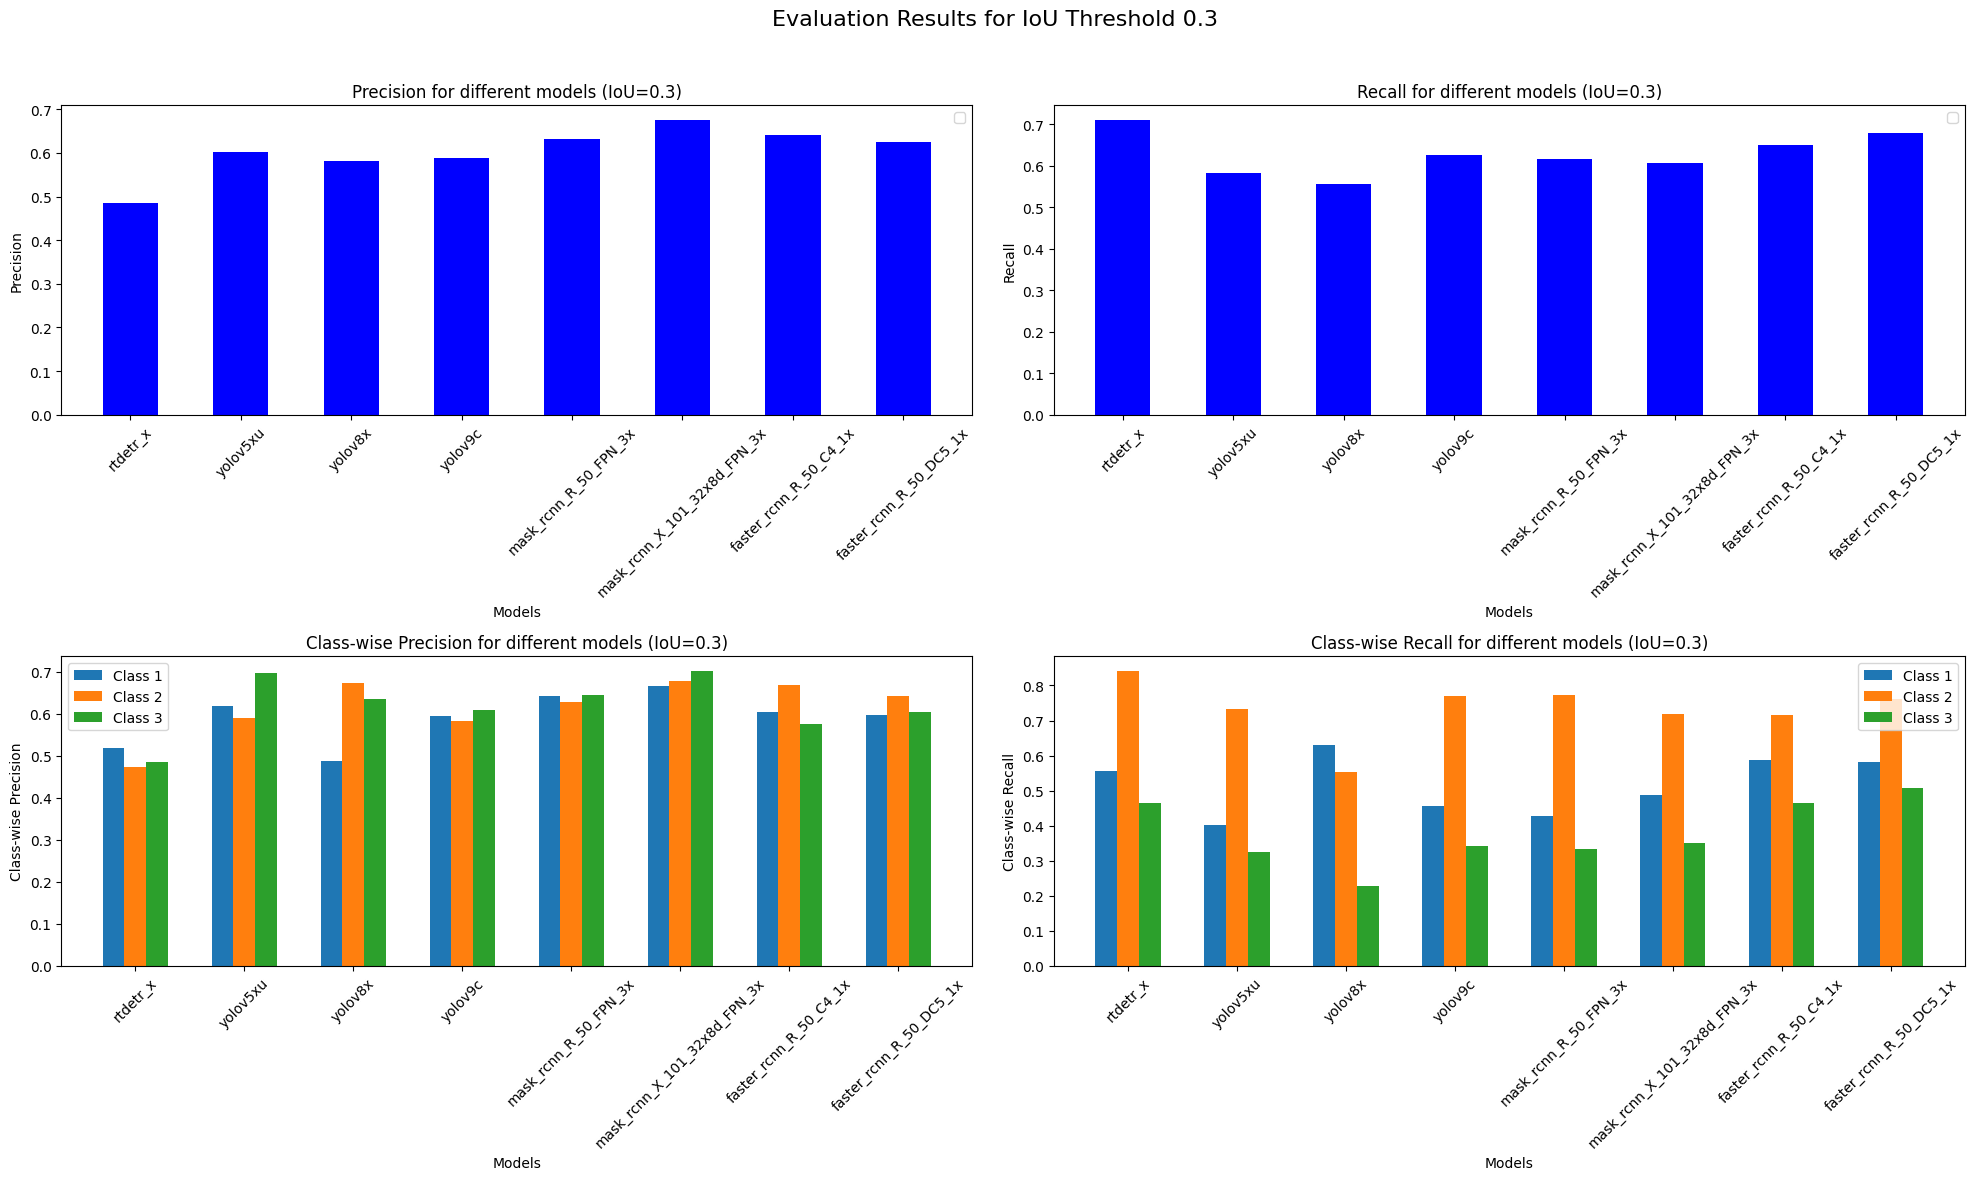

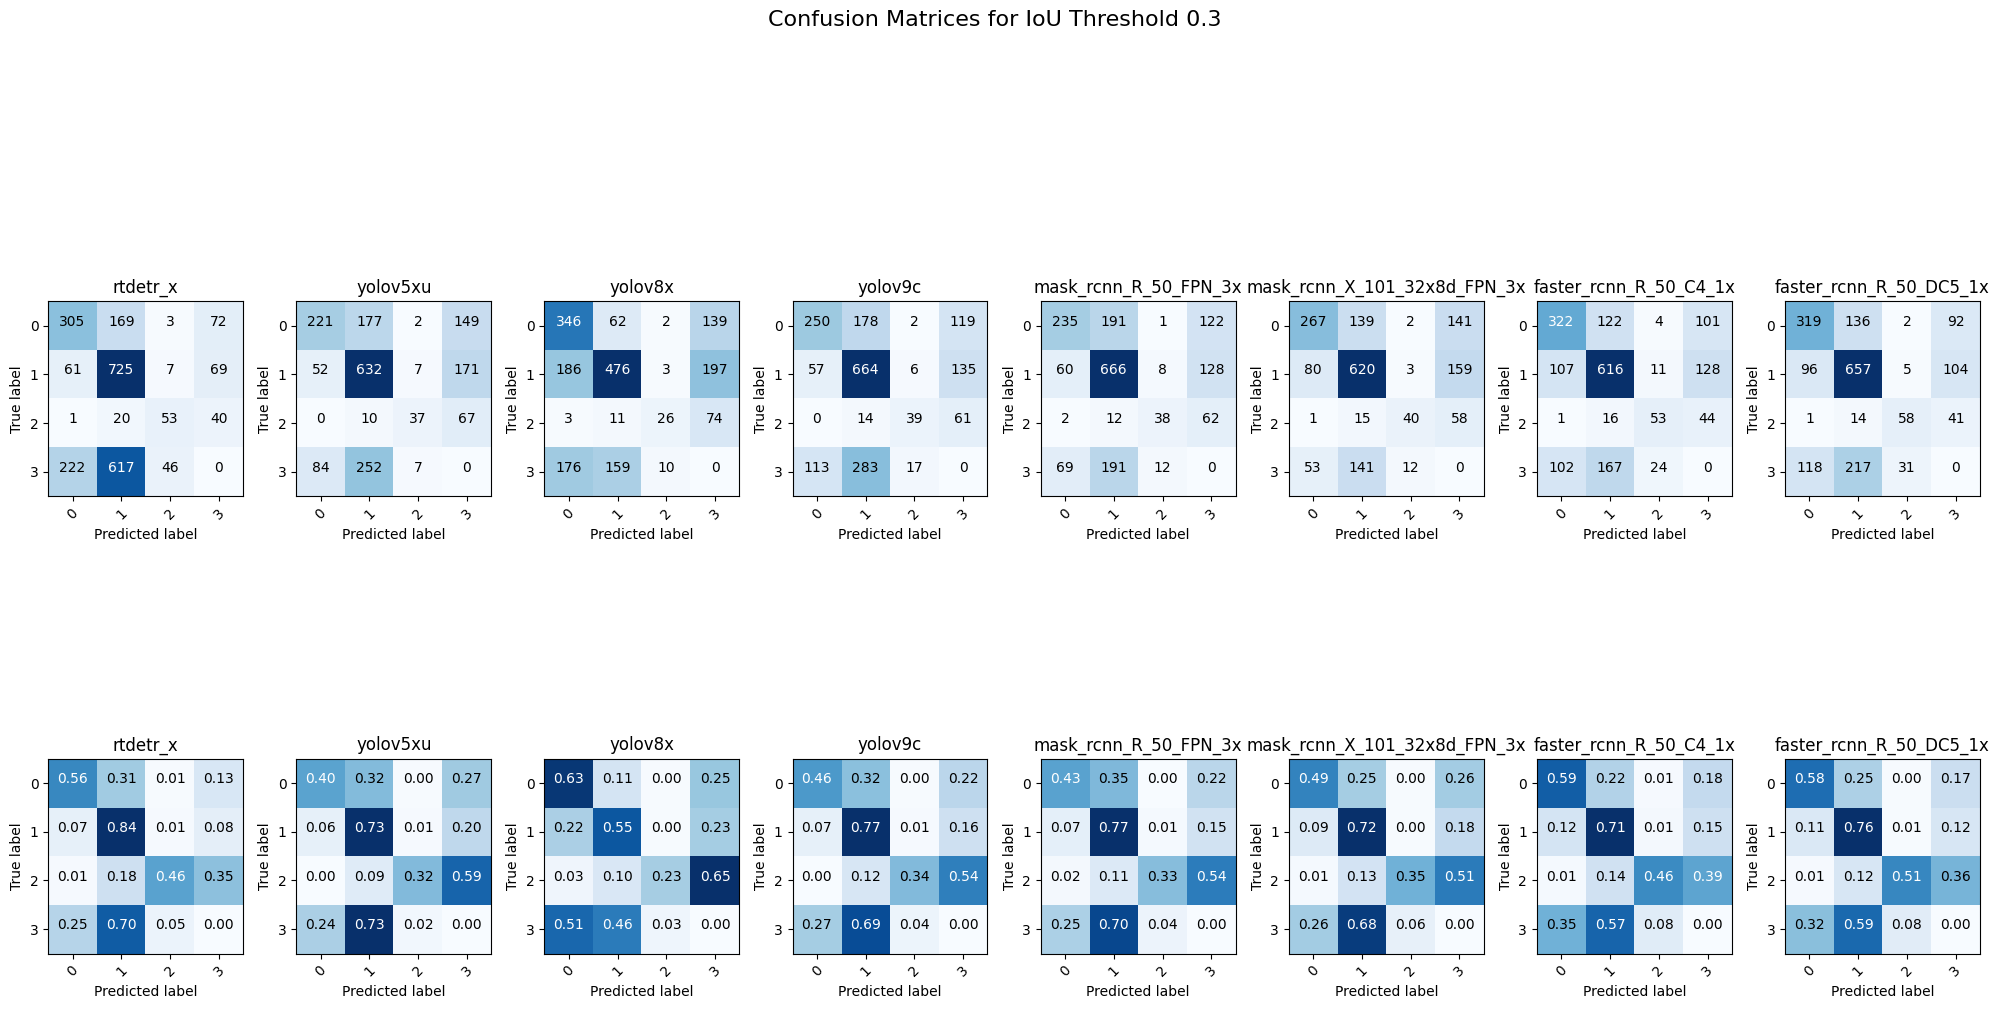

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.35


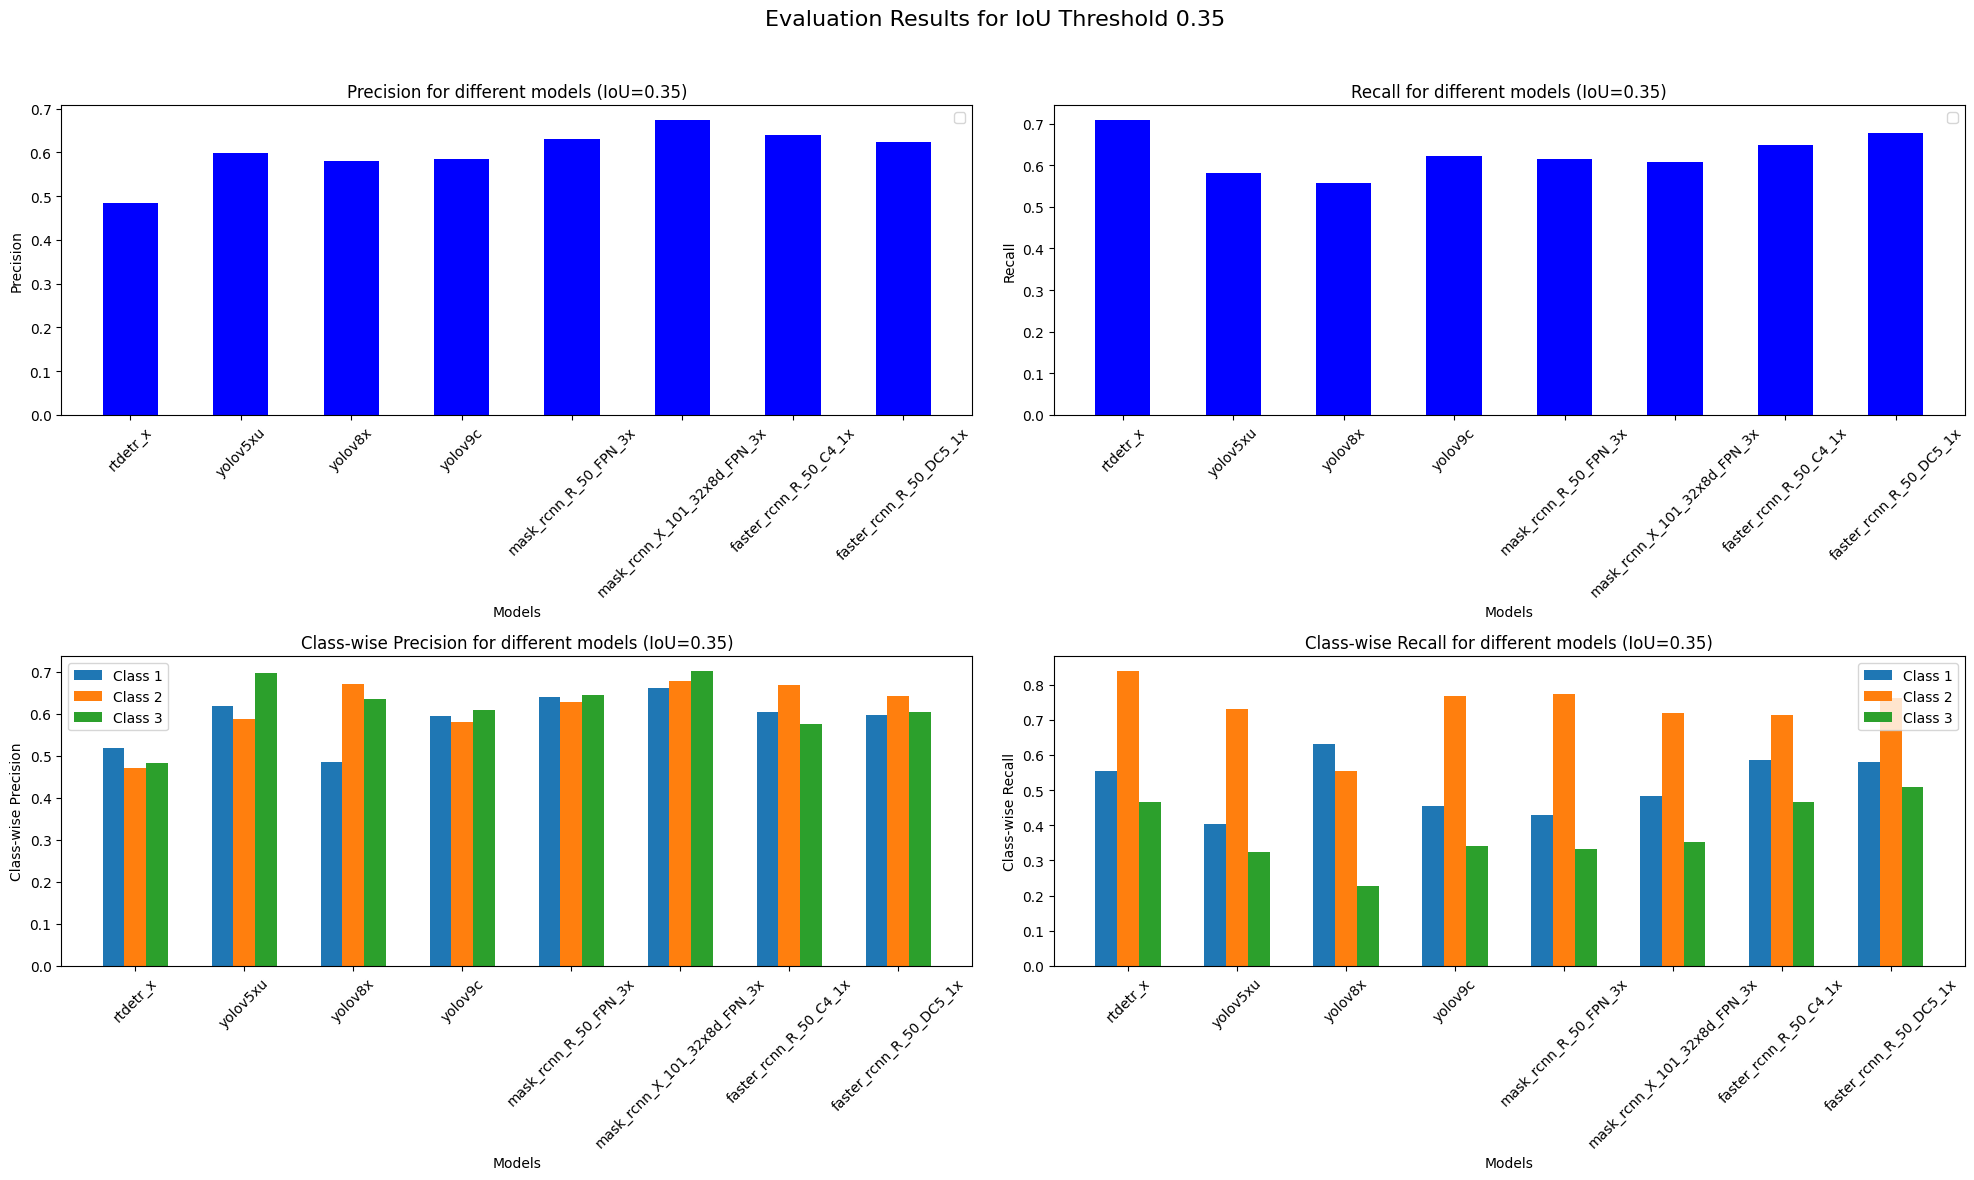

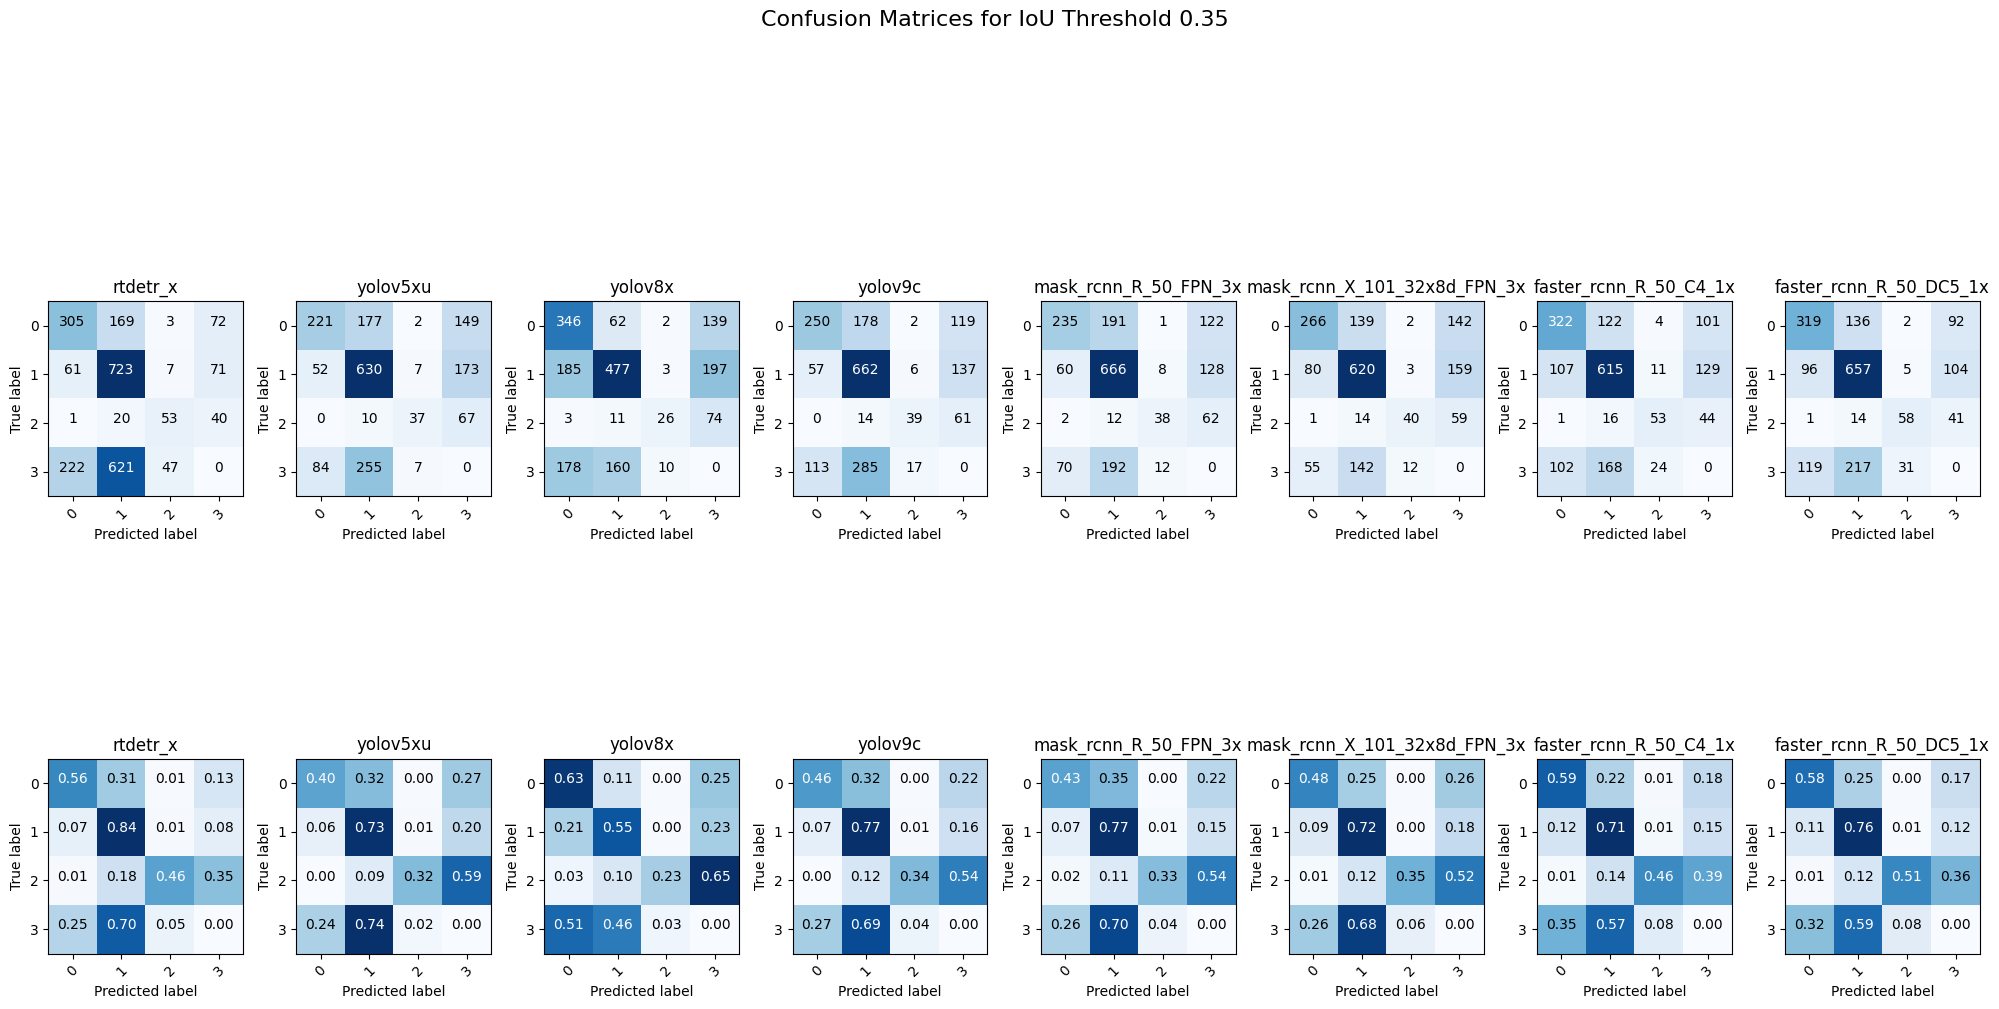

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.4


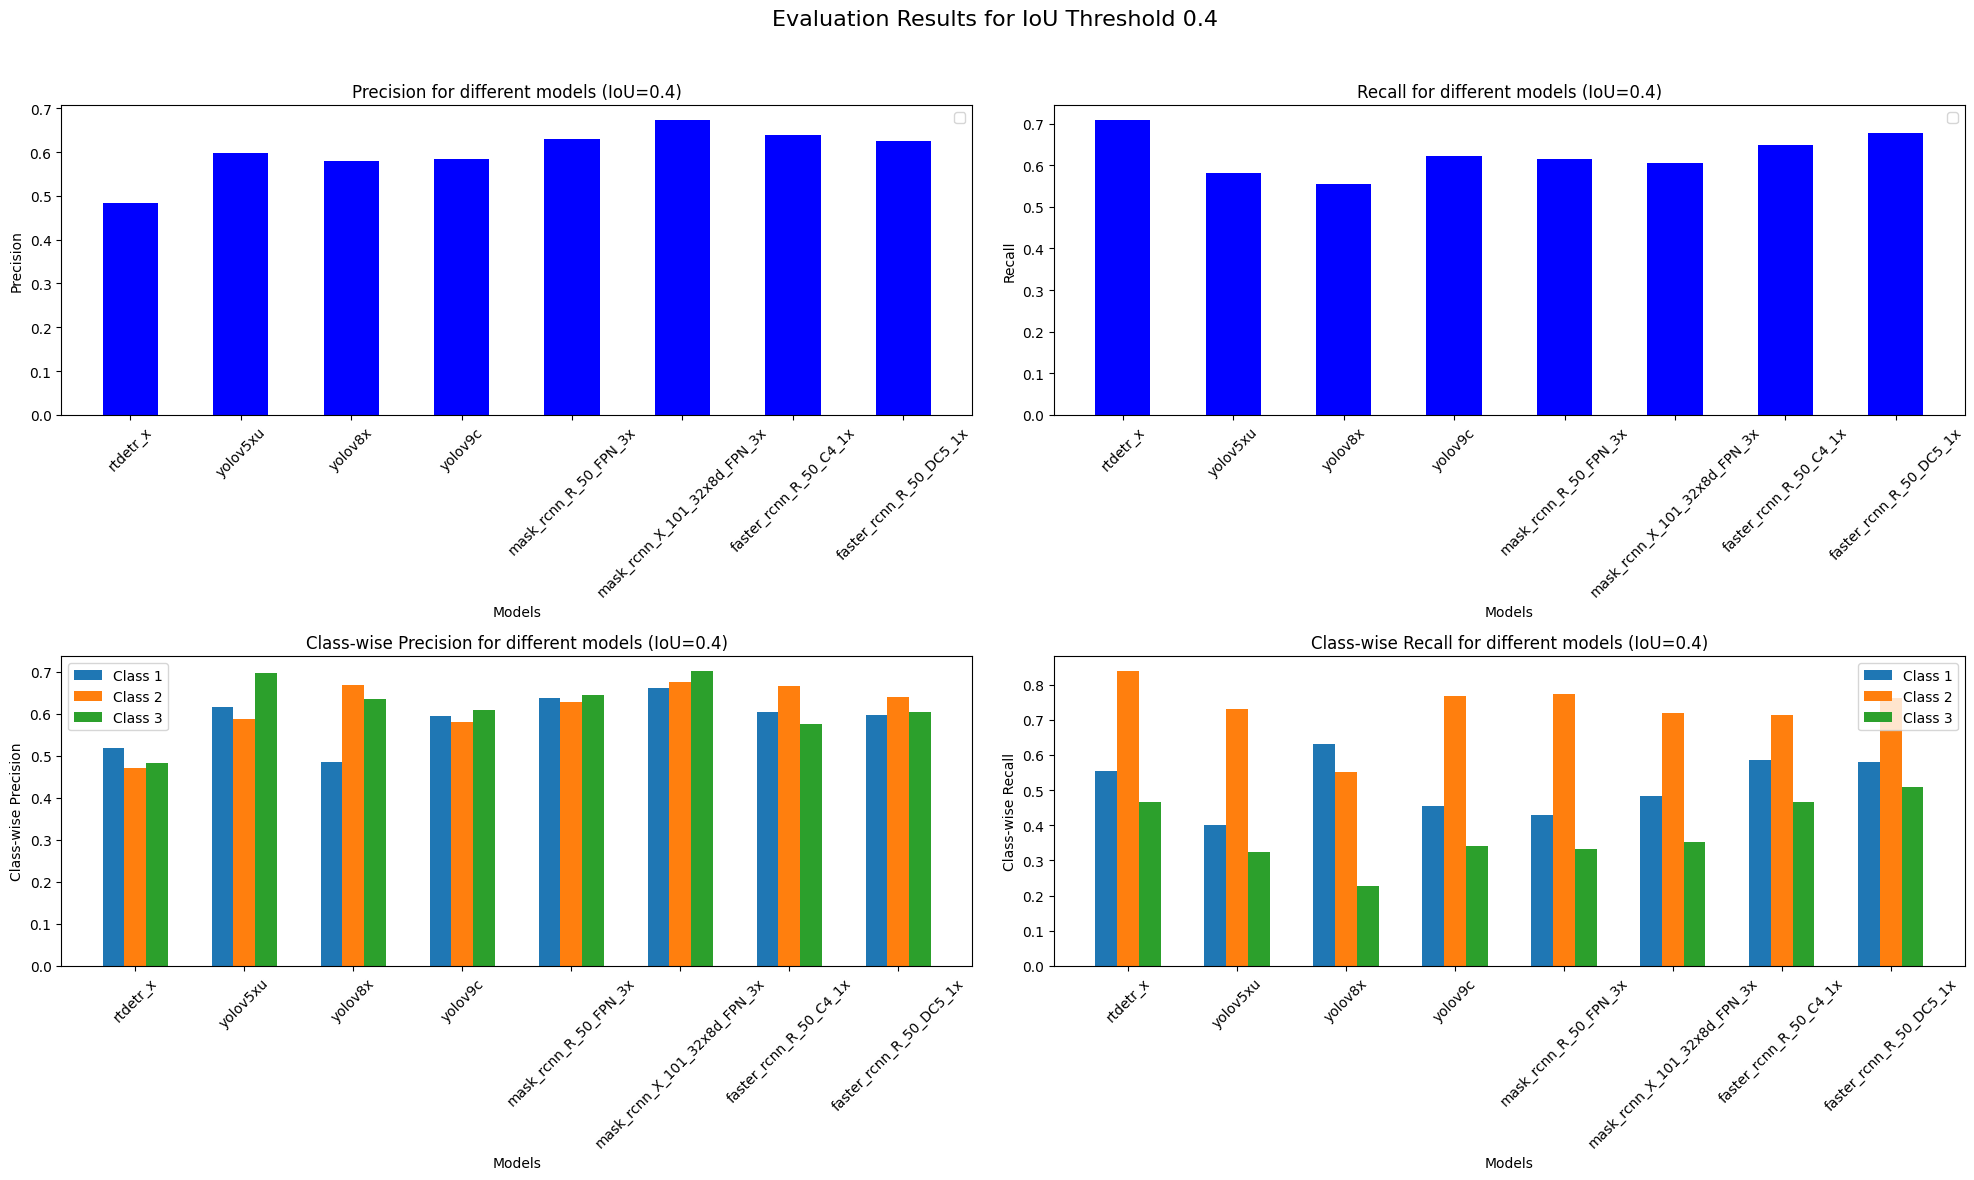

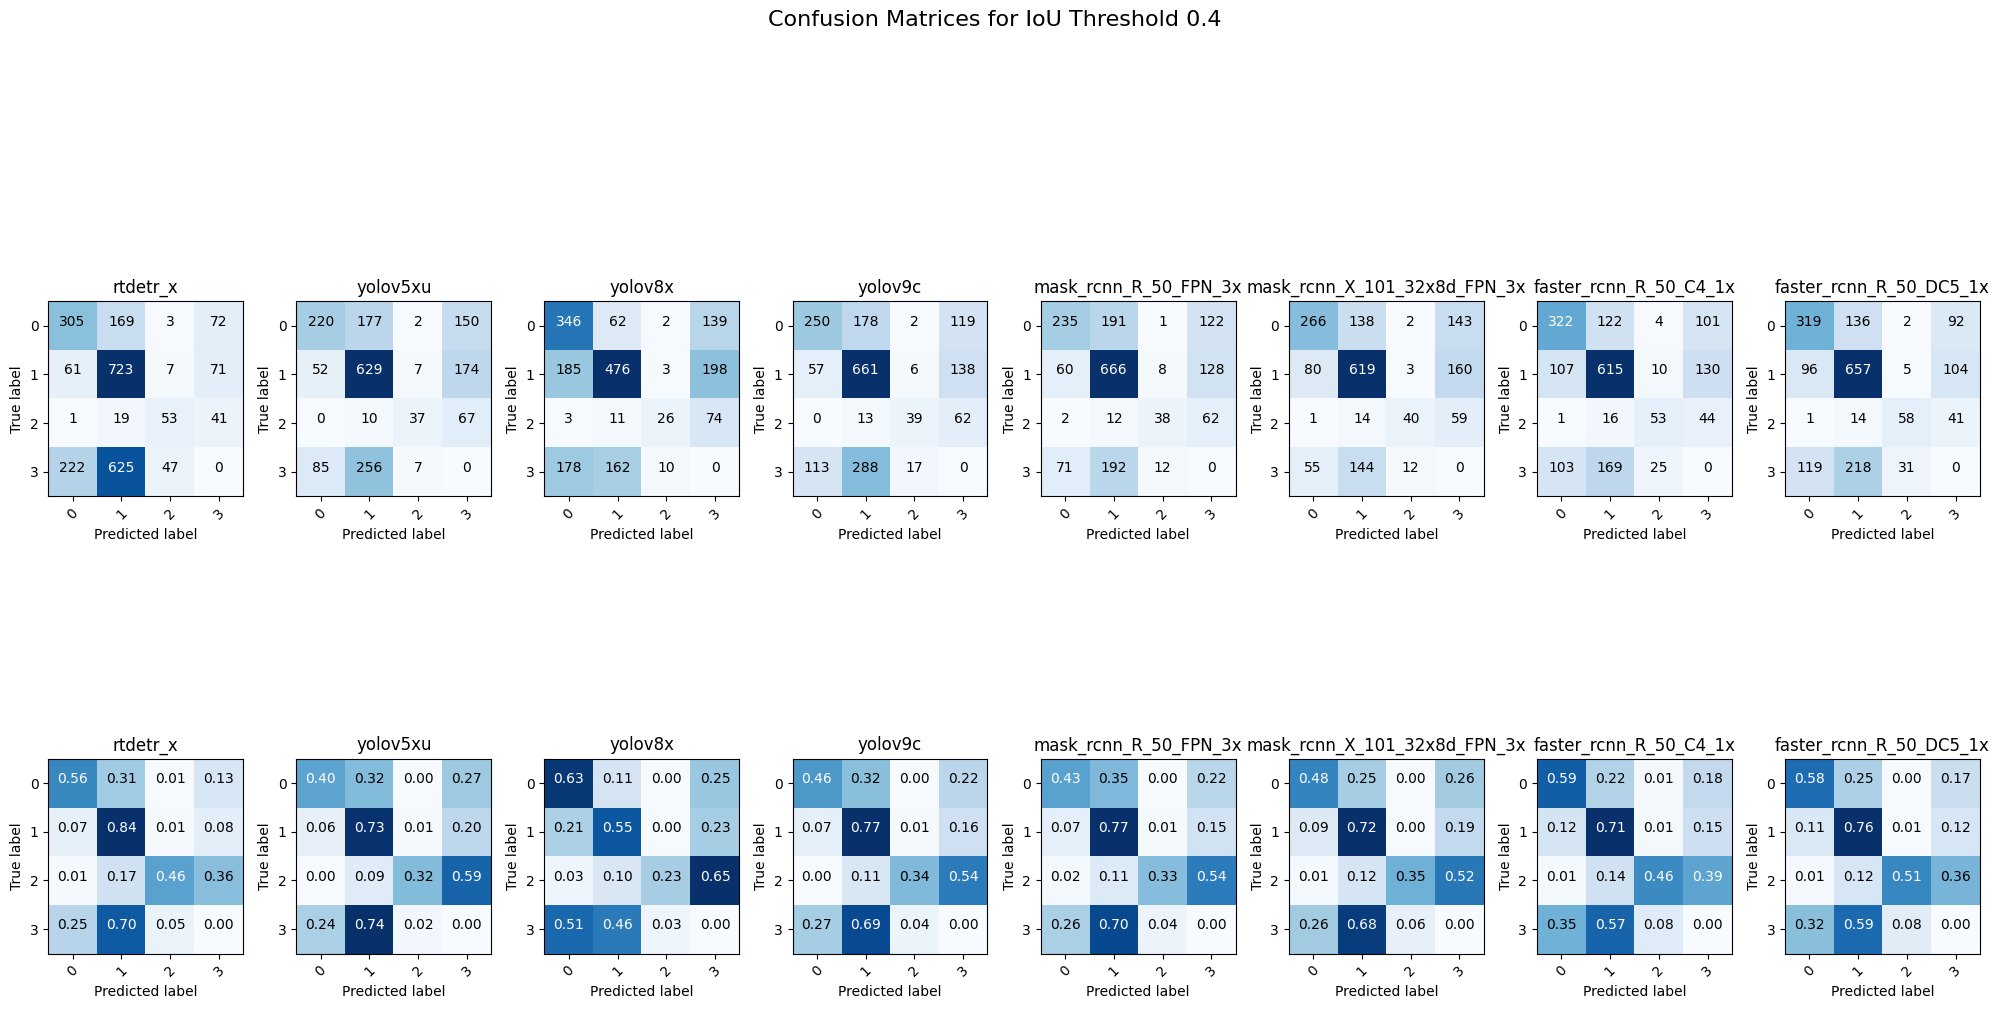

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.45


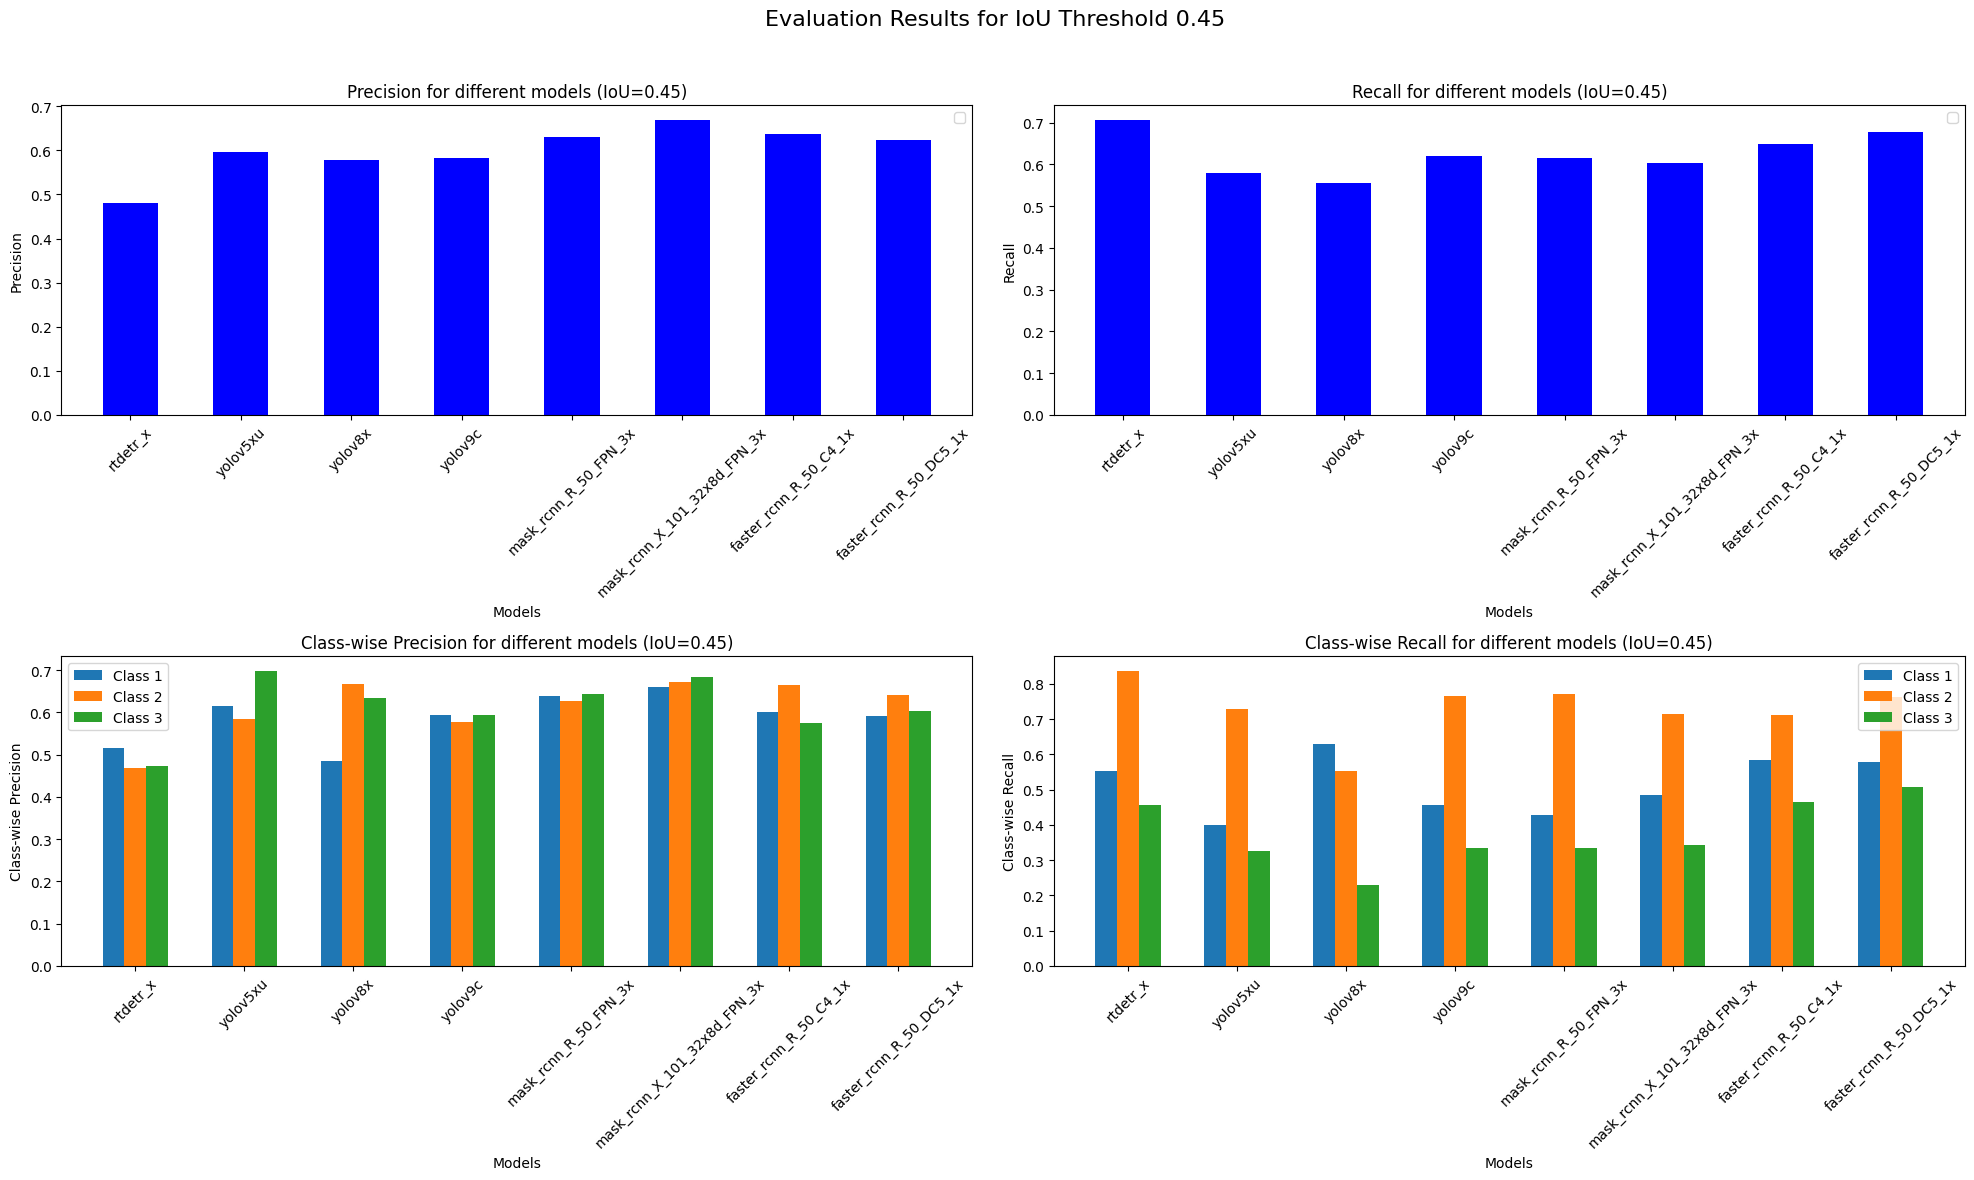

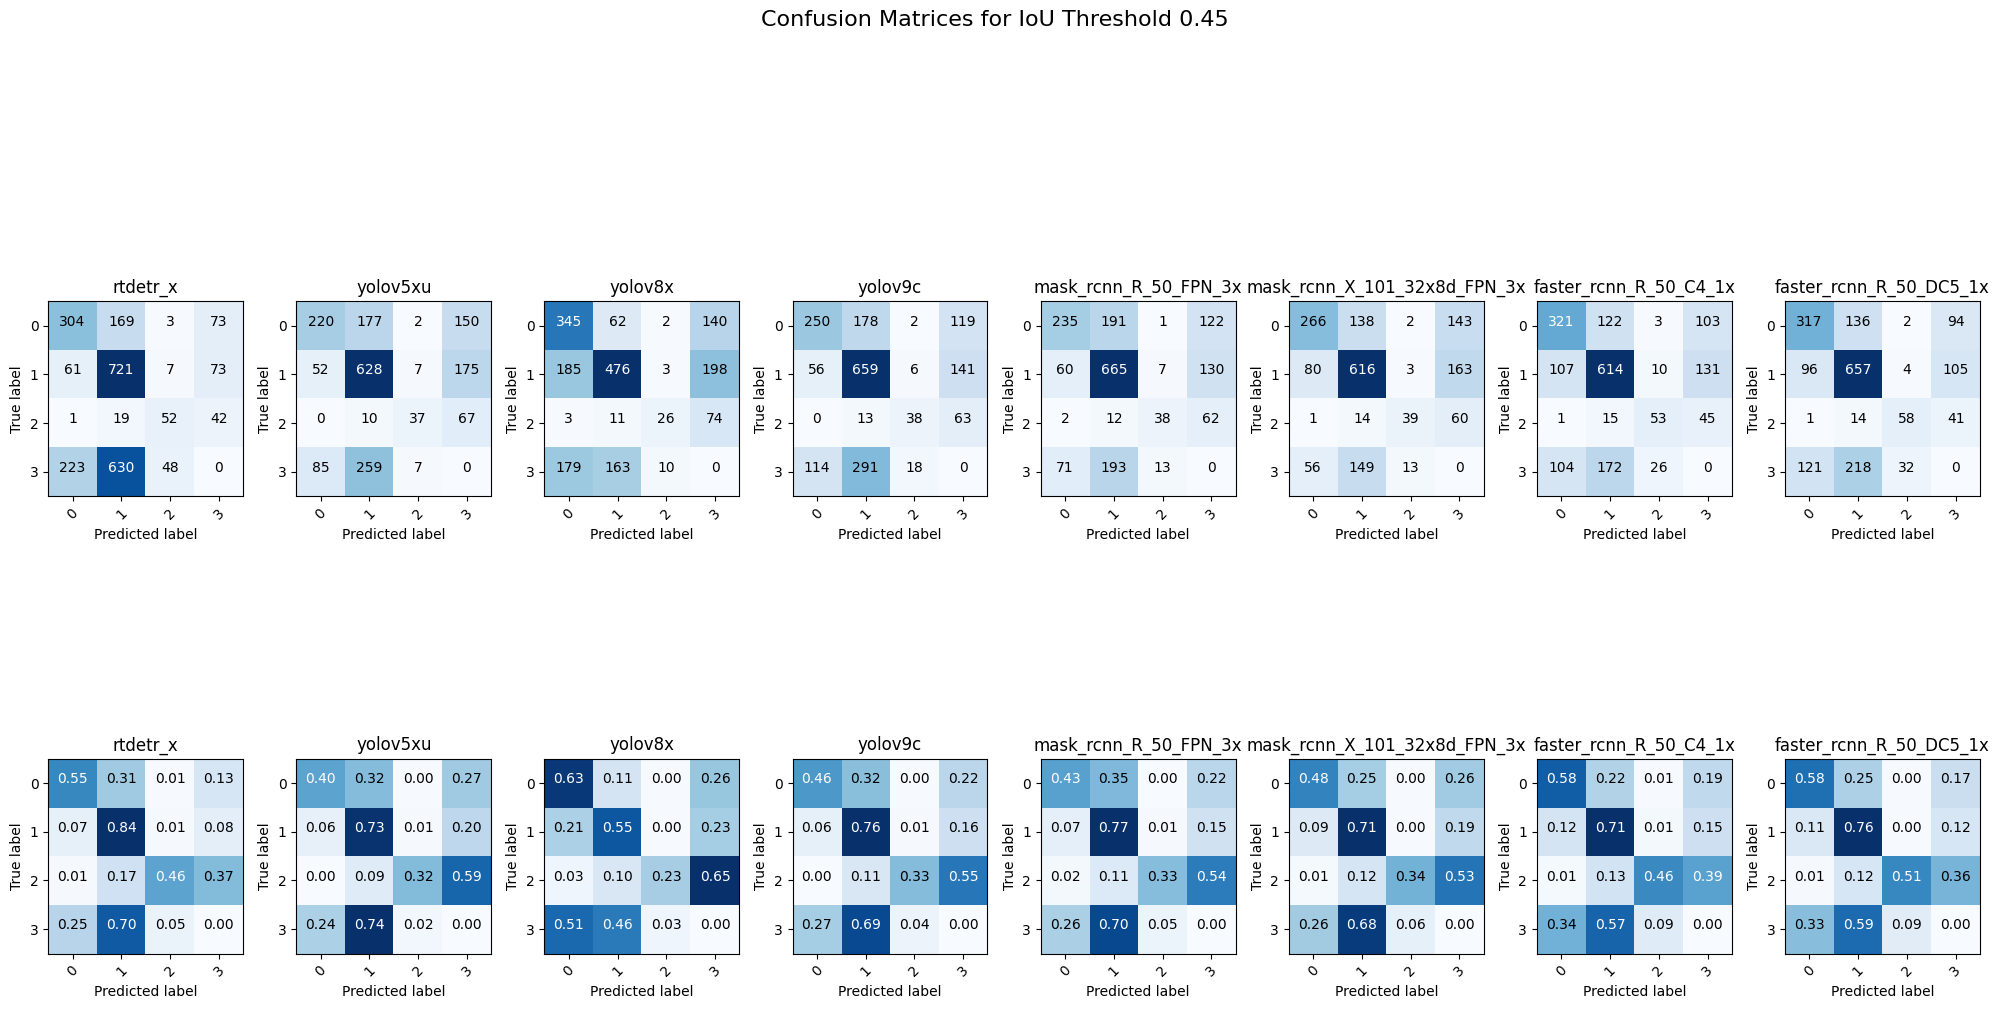

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.5


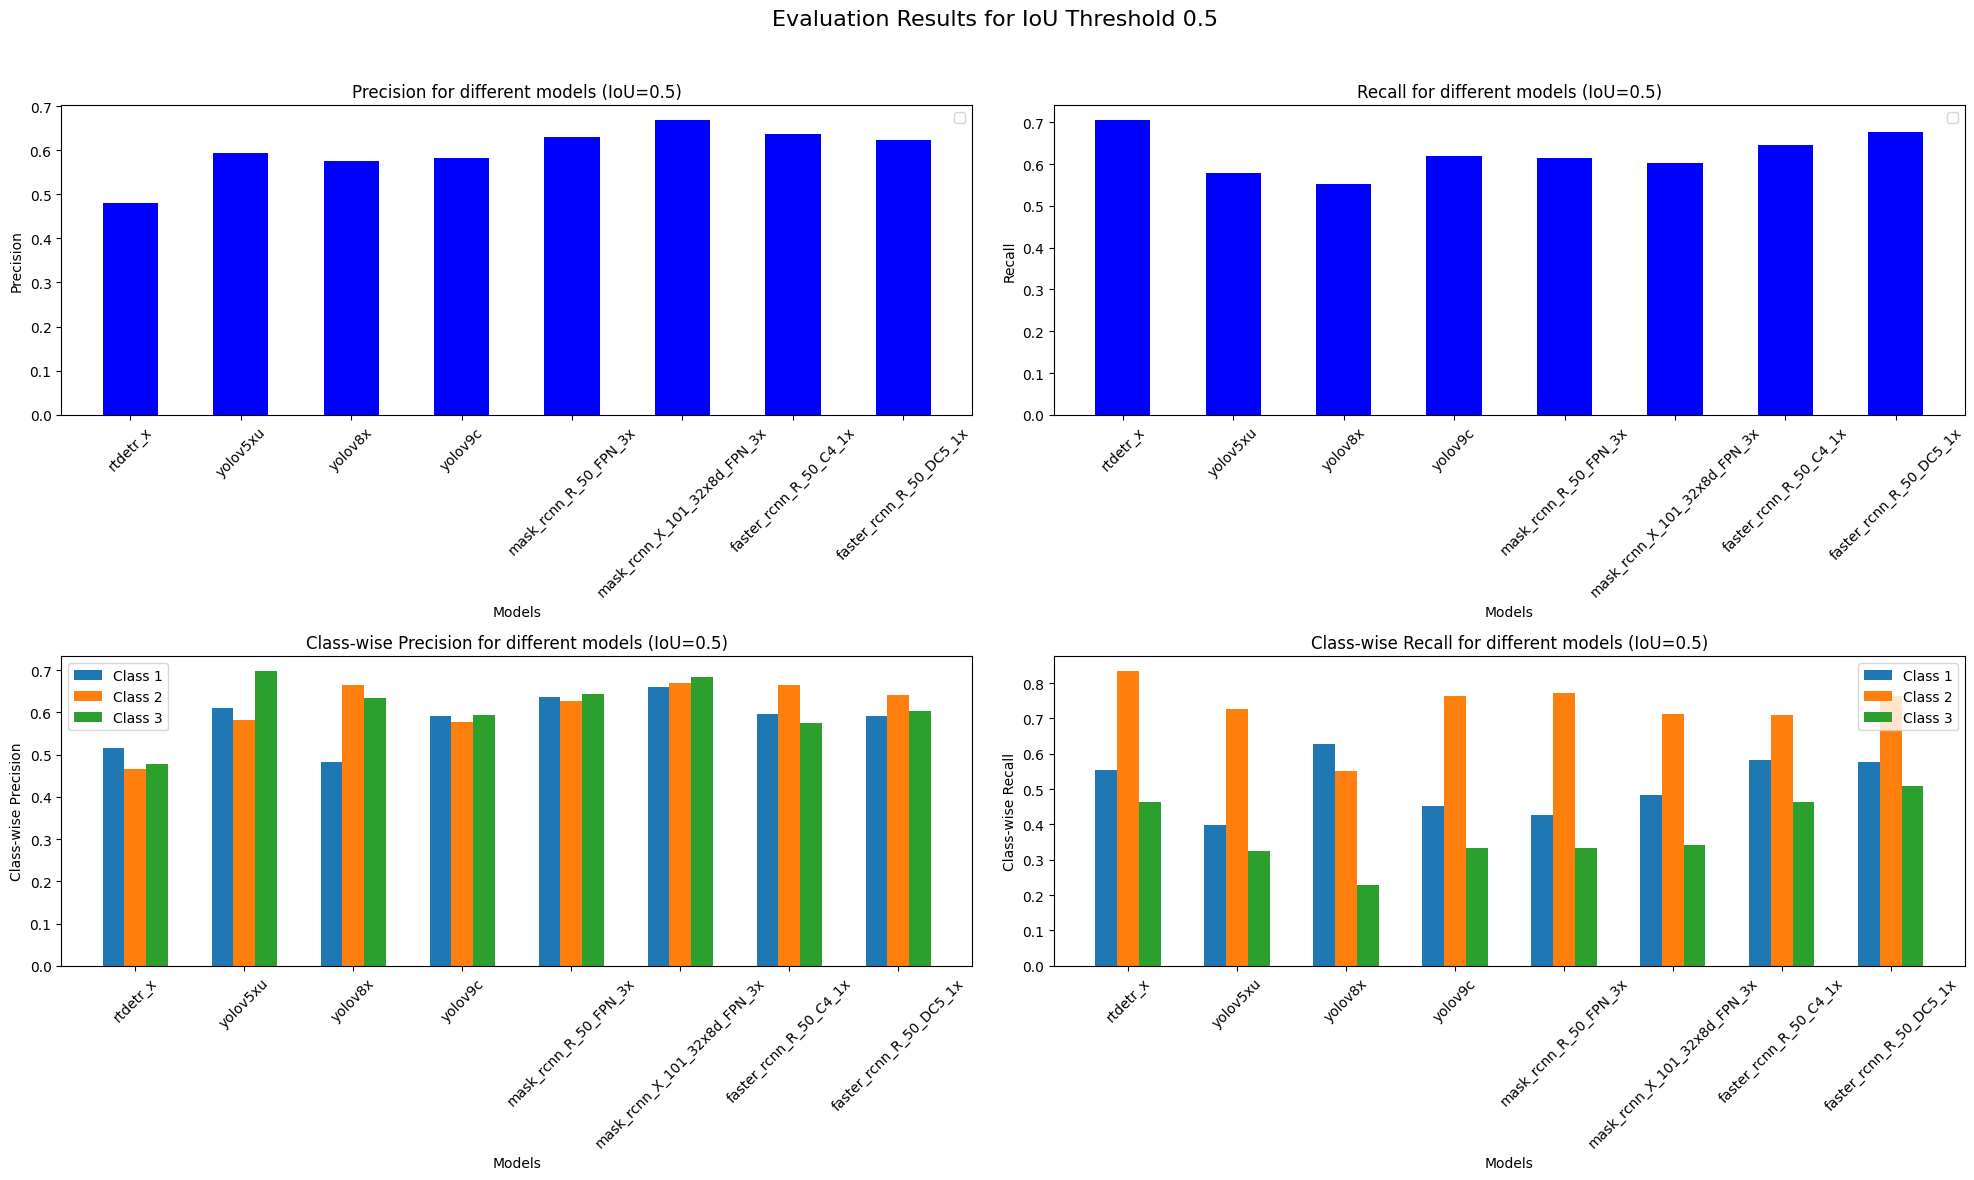

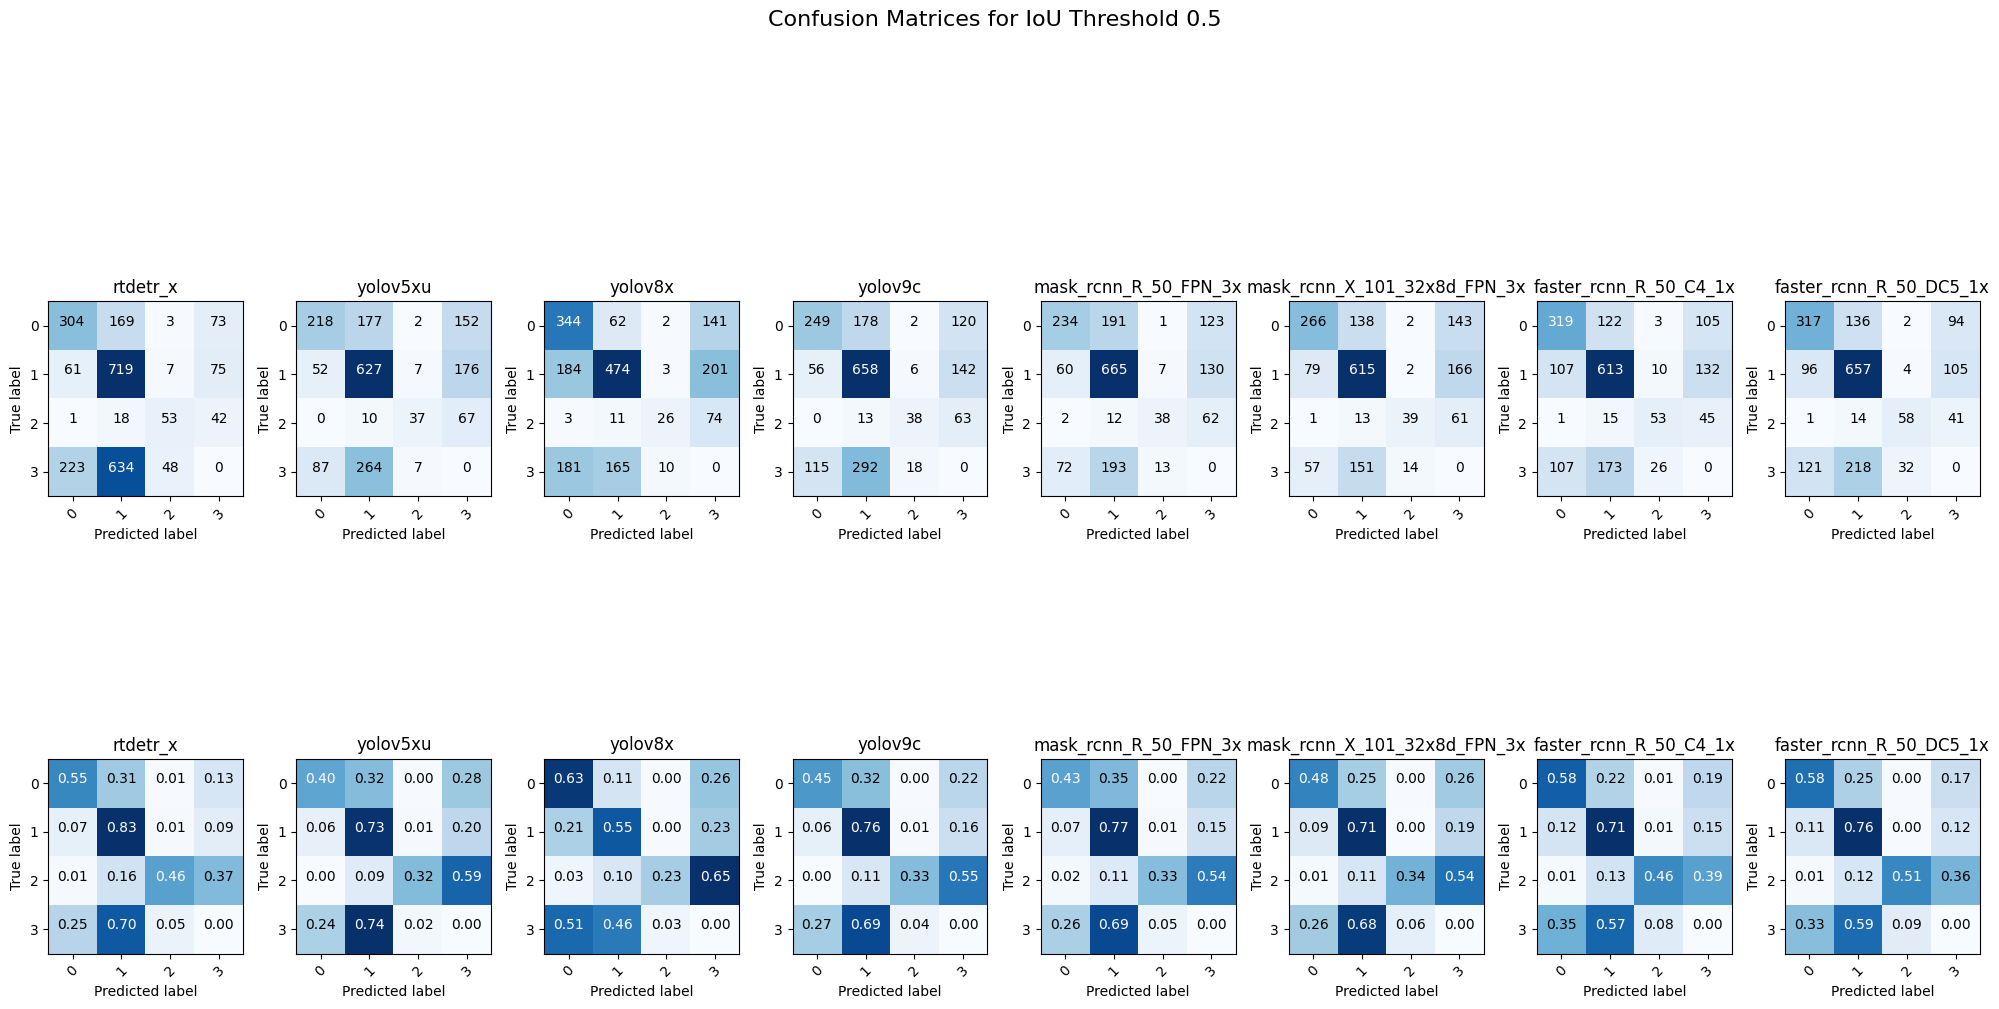

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.55


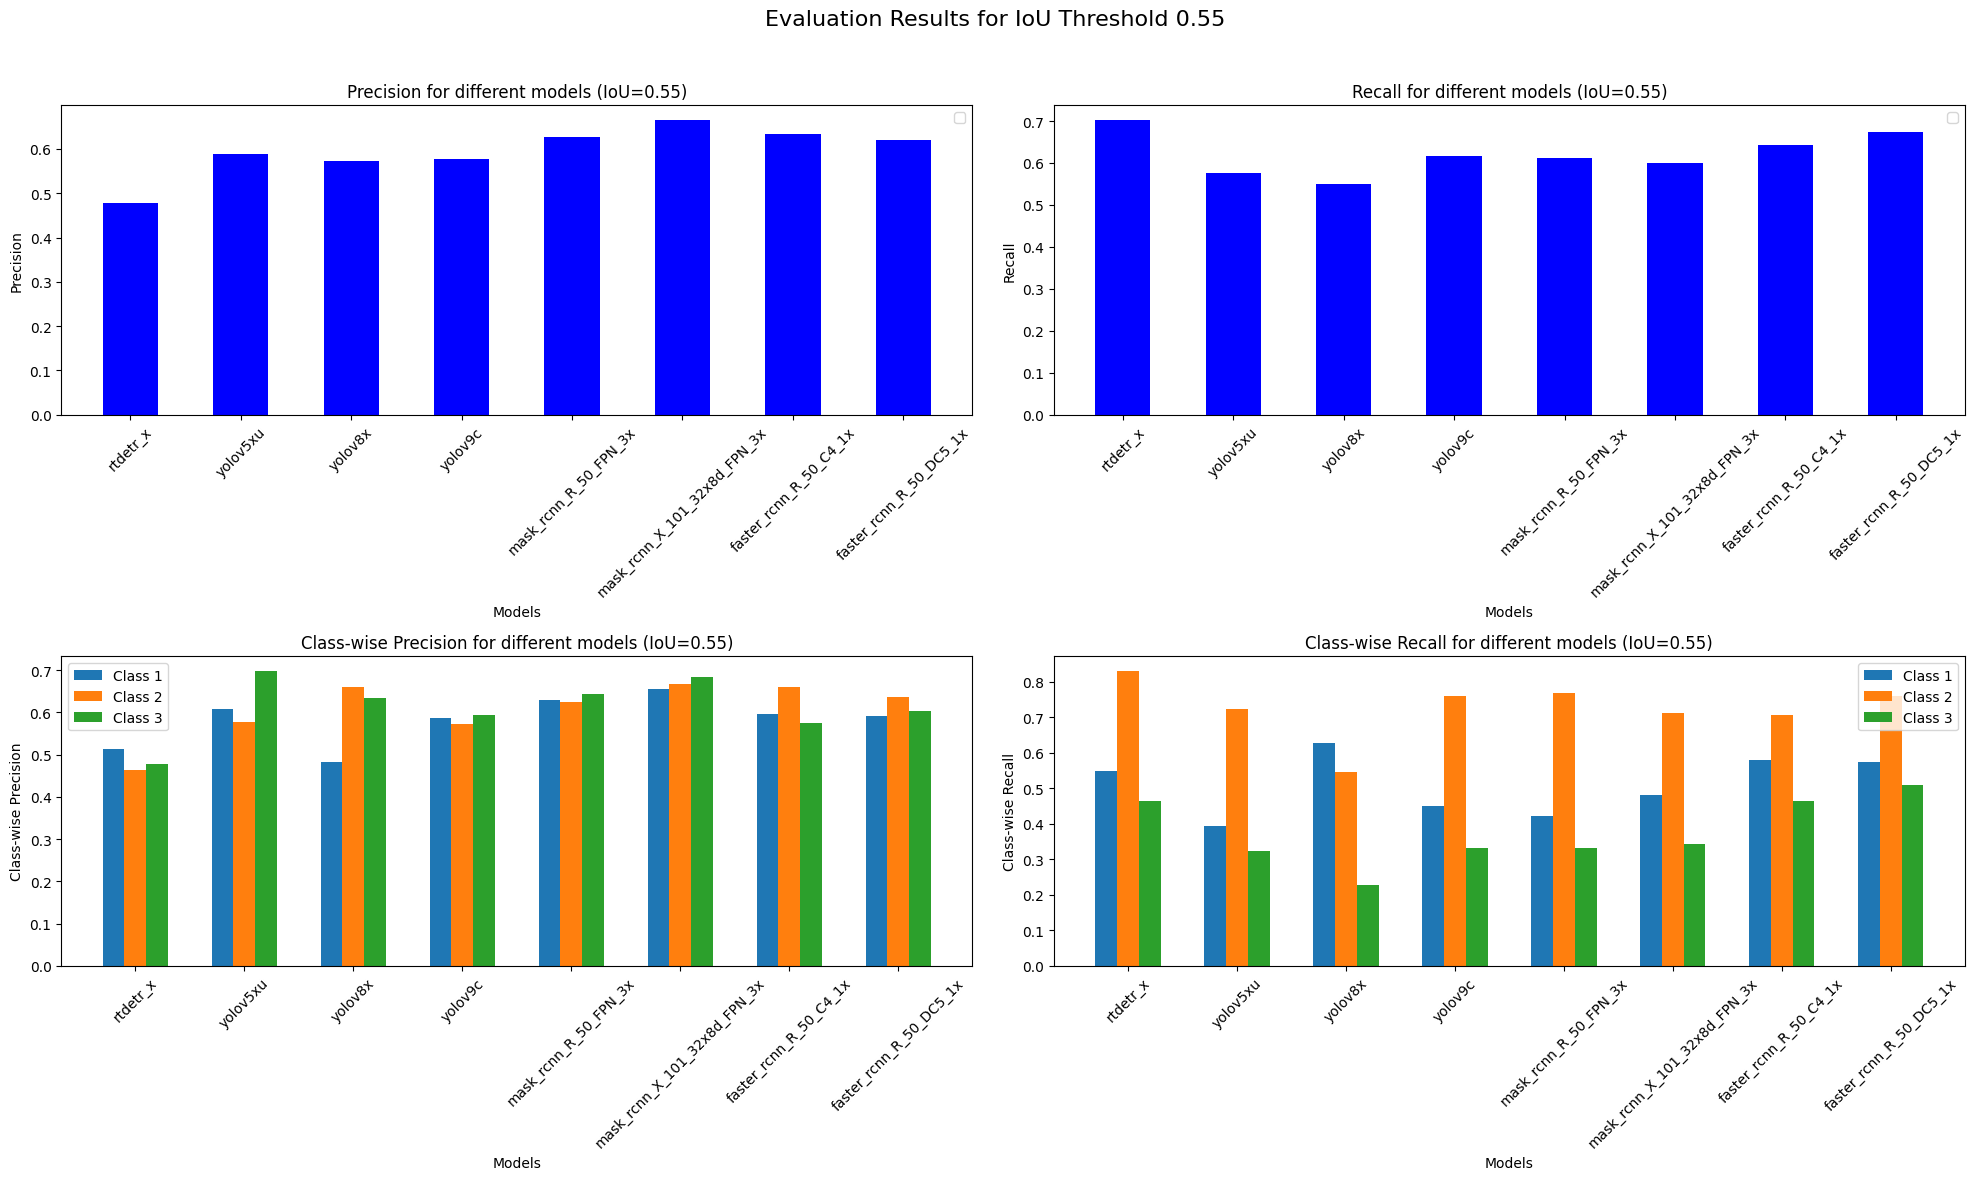

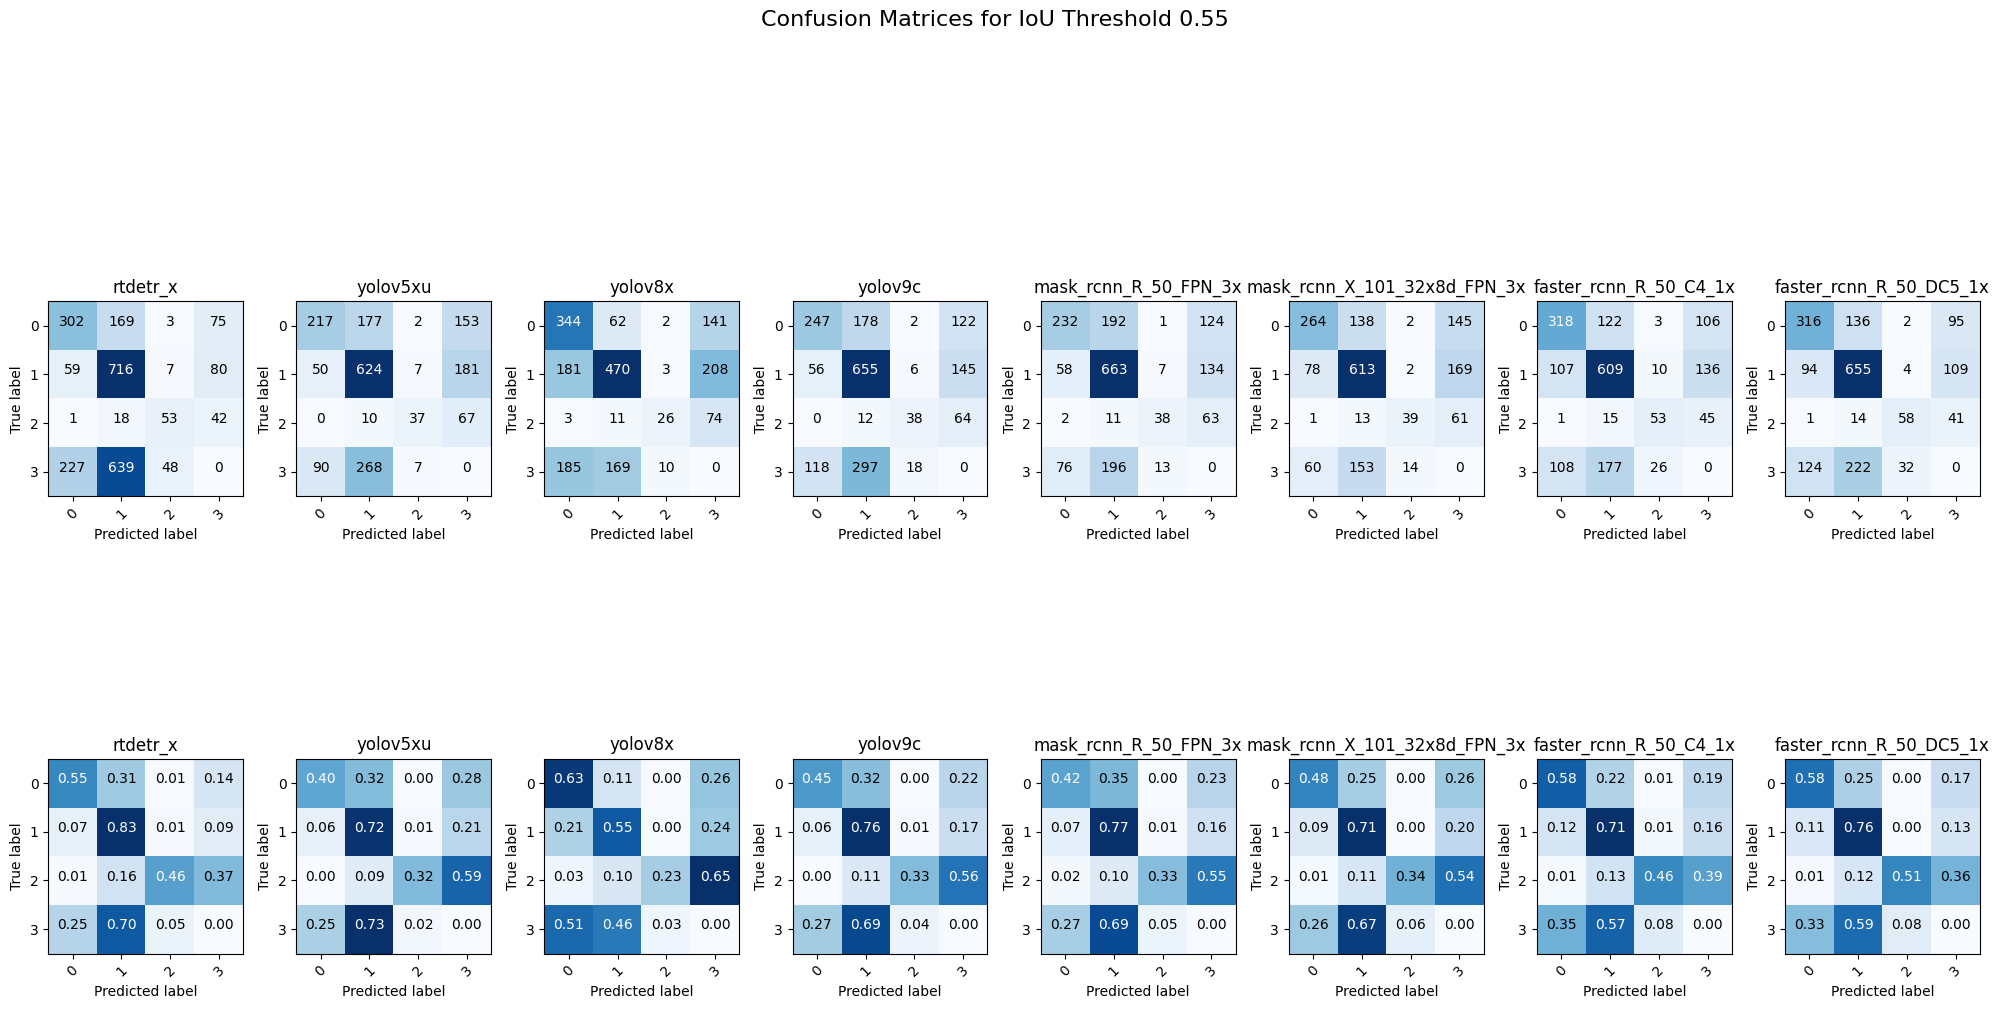

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.6


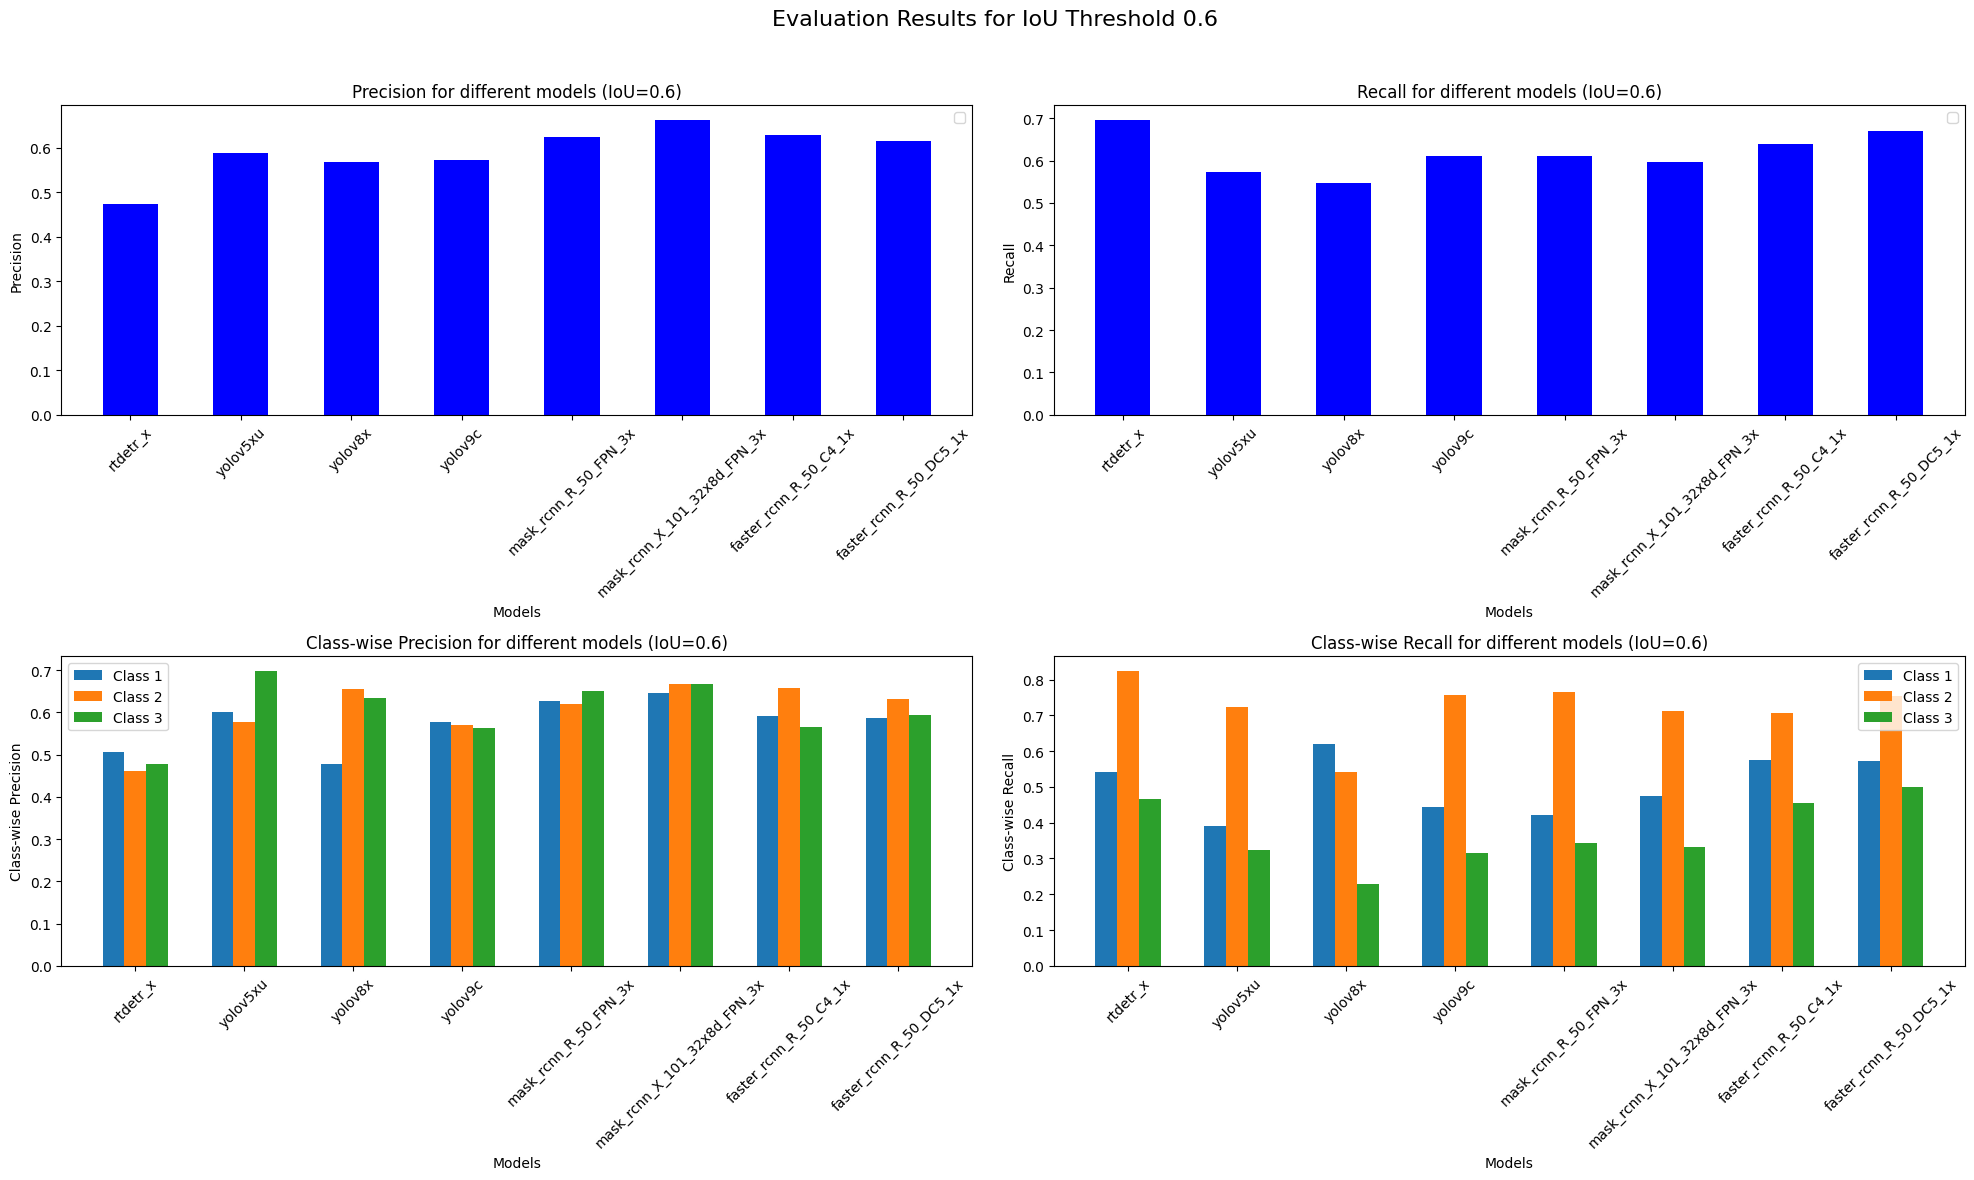

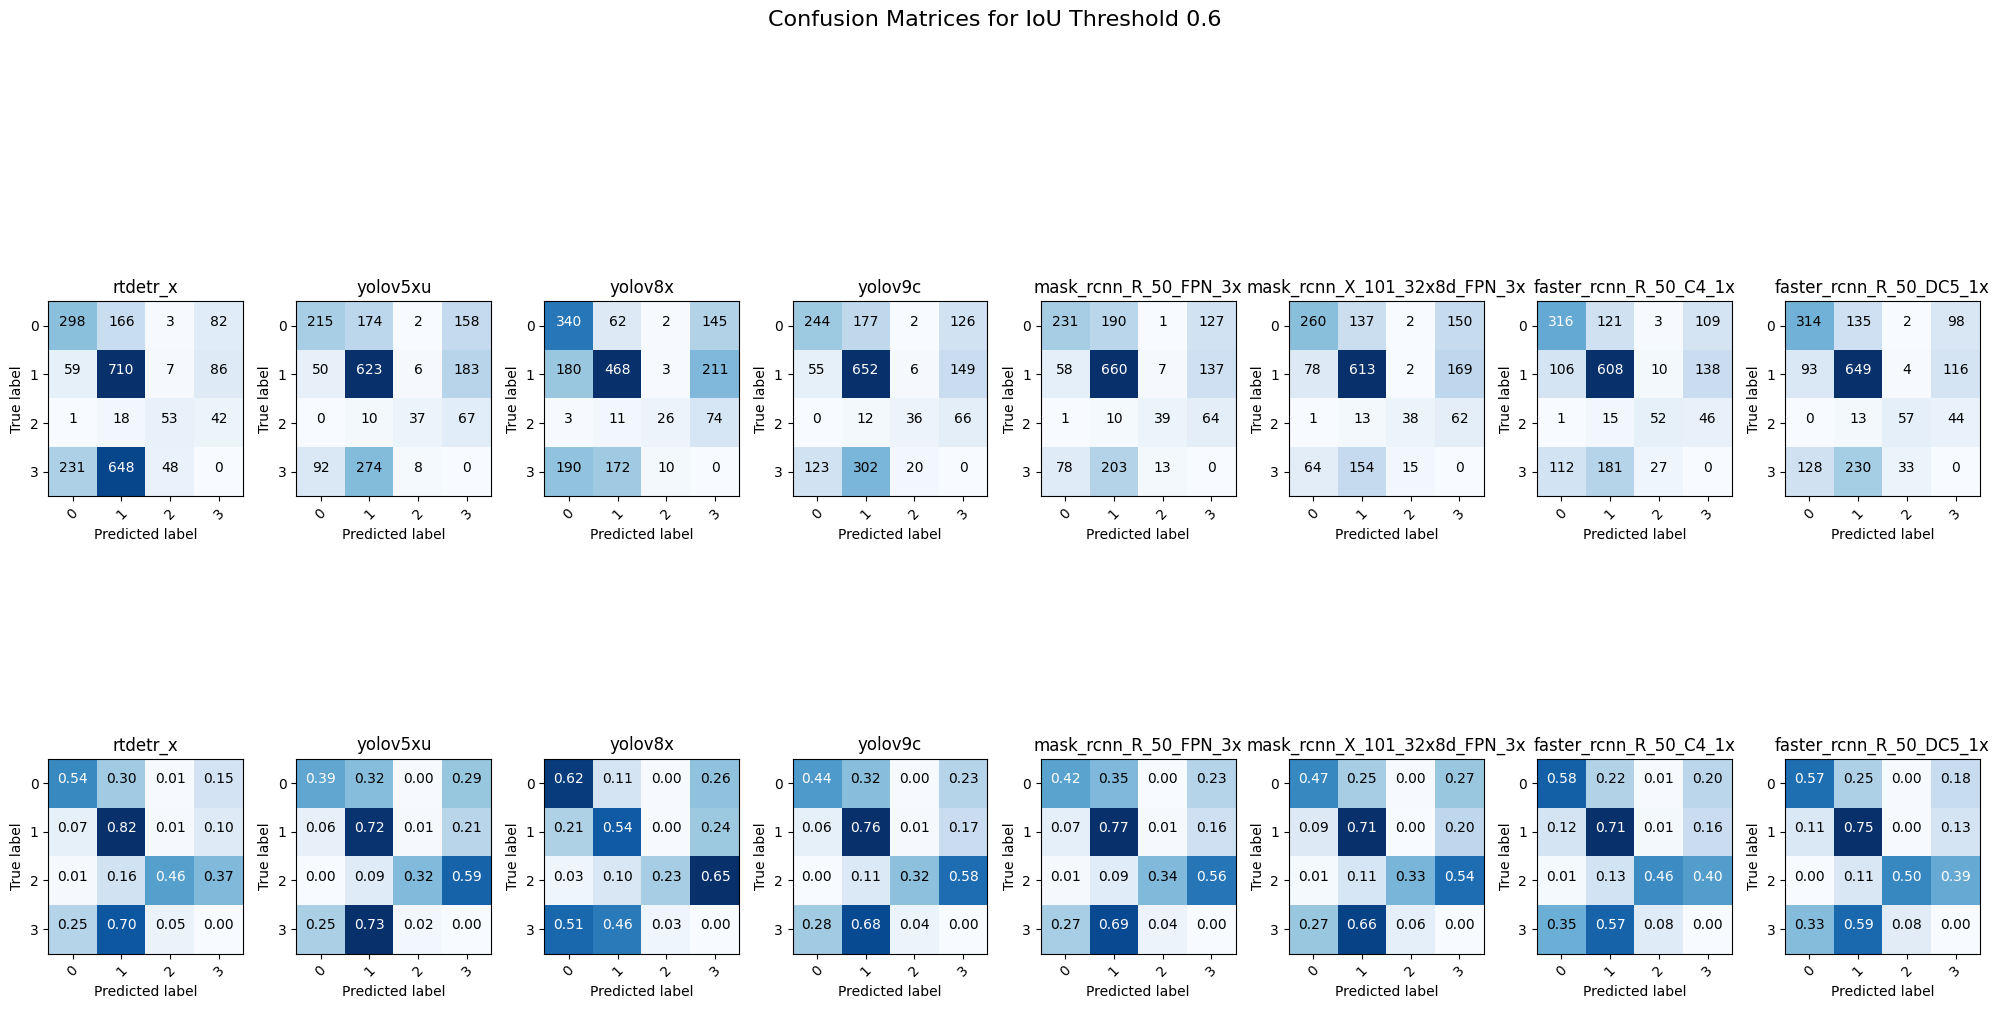

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.65


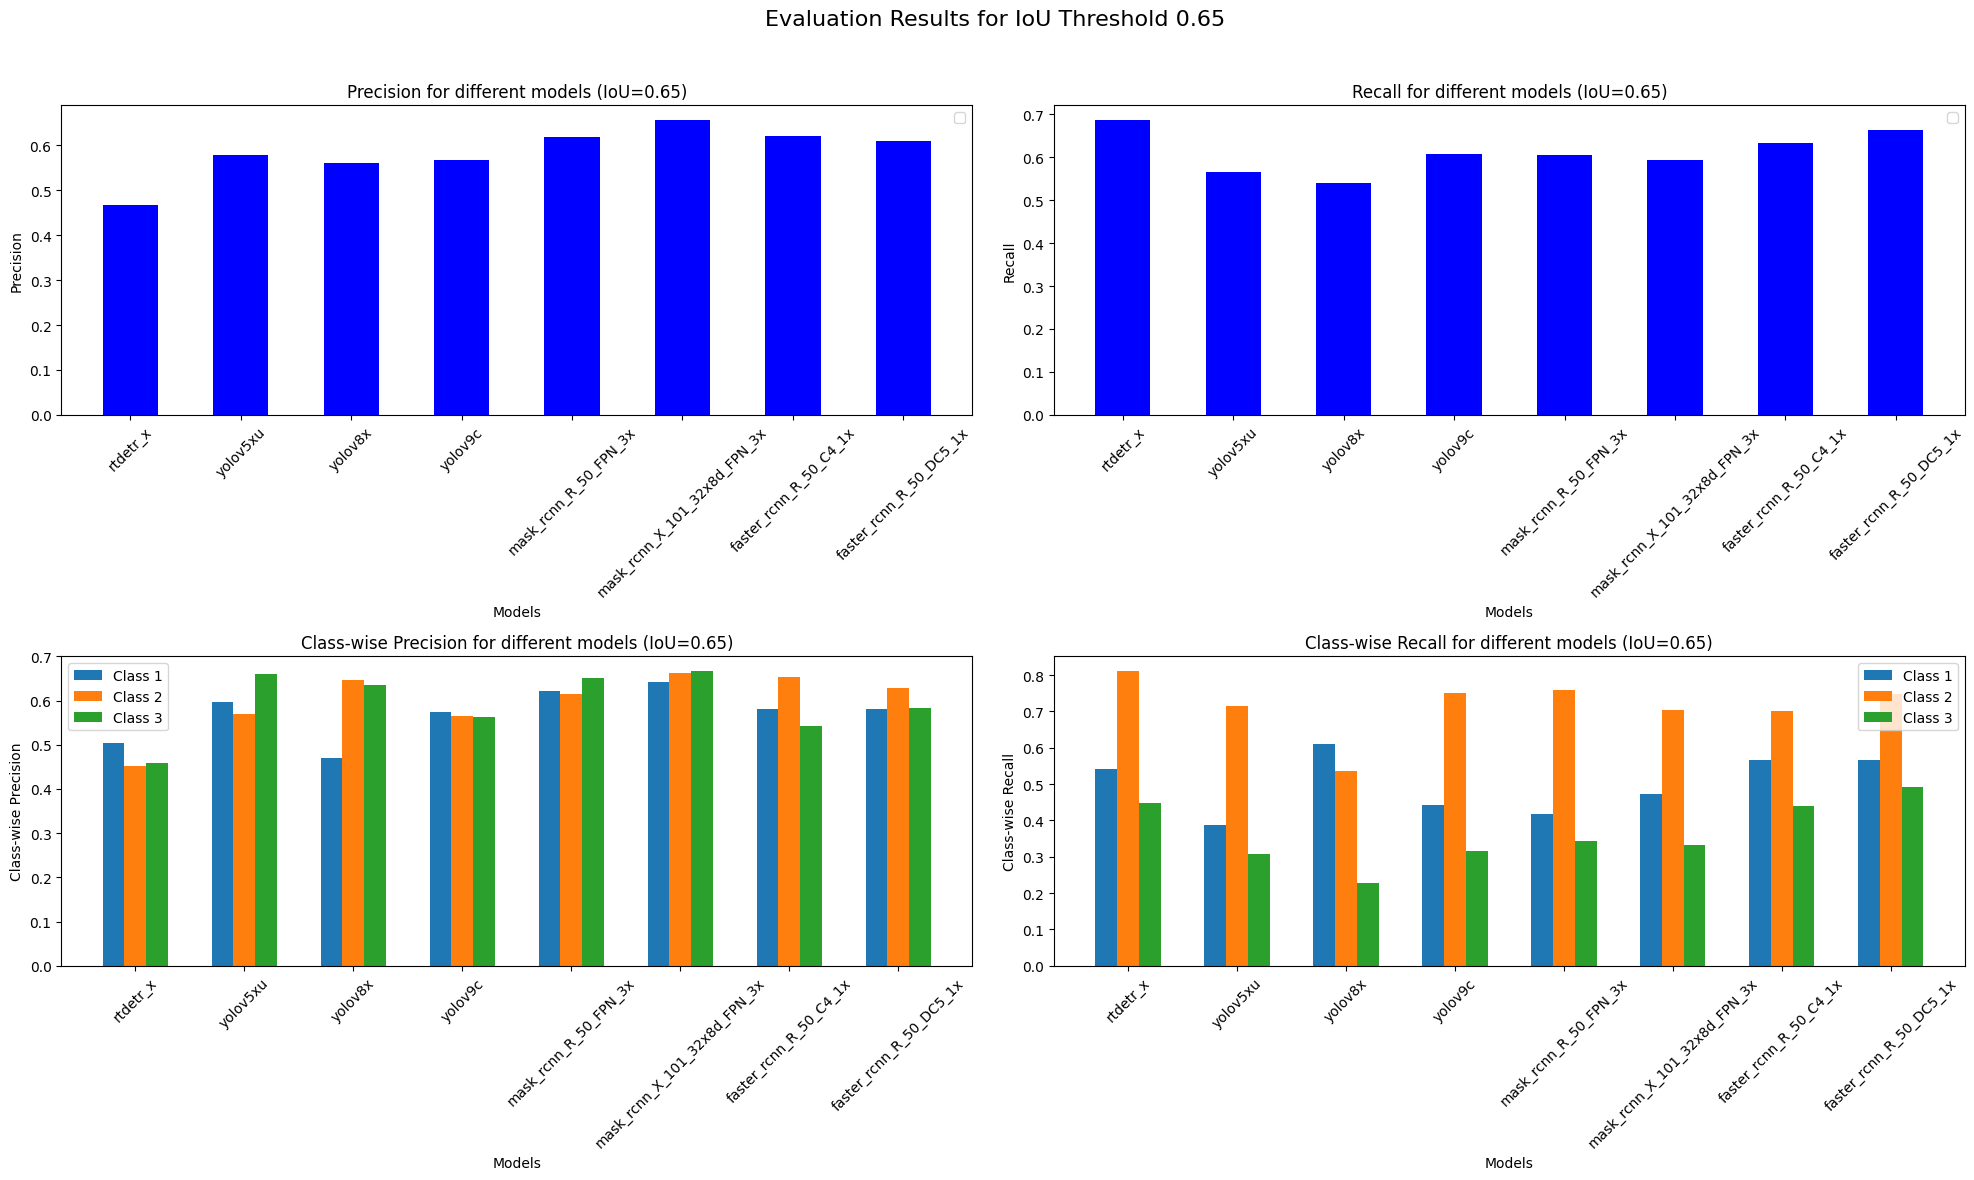

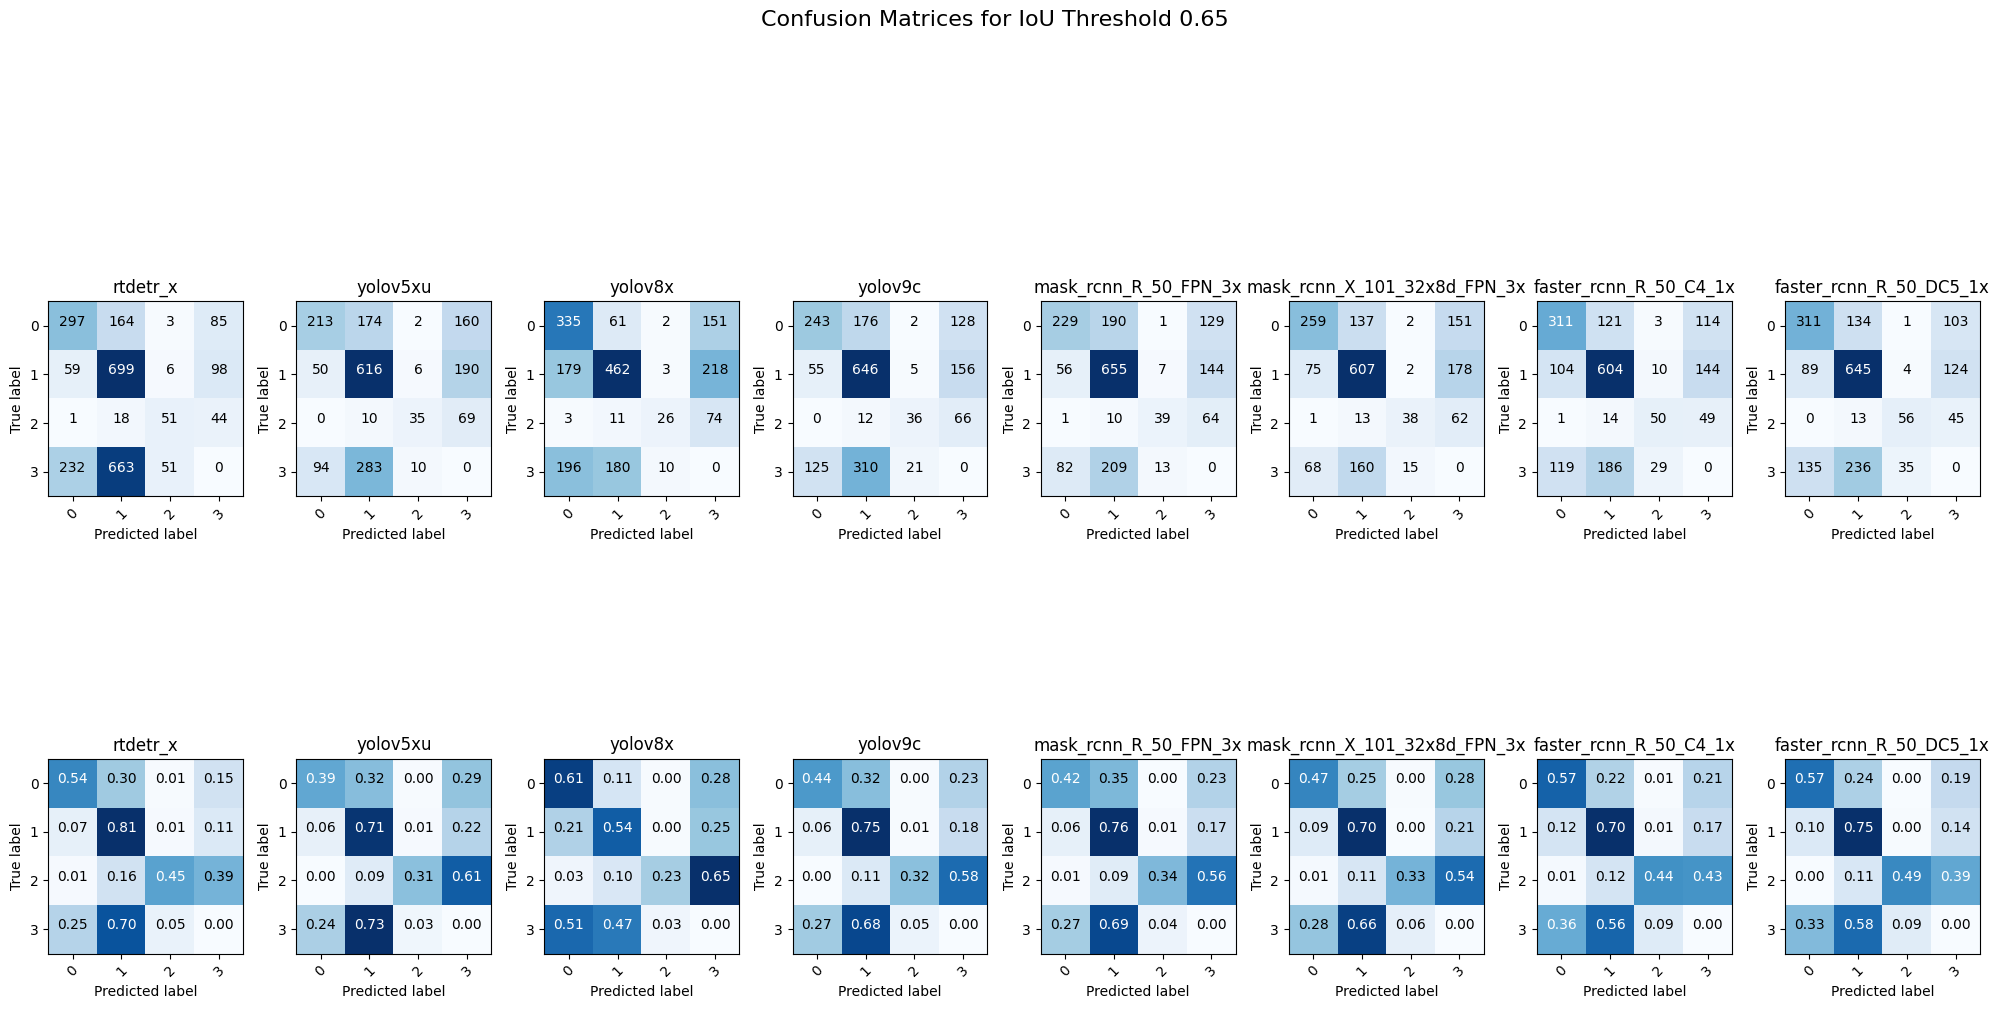

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.7


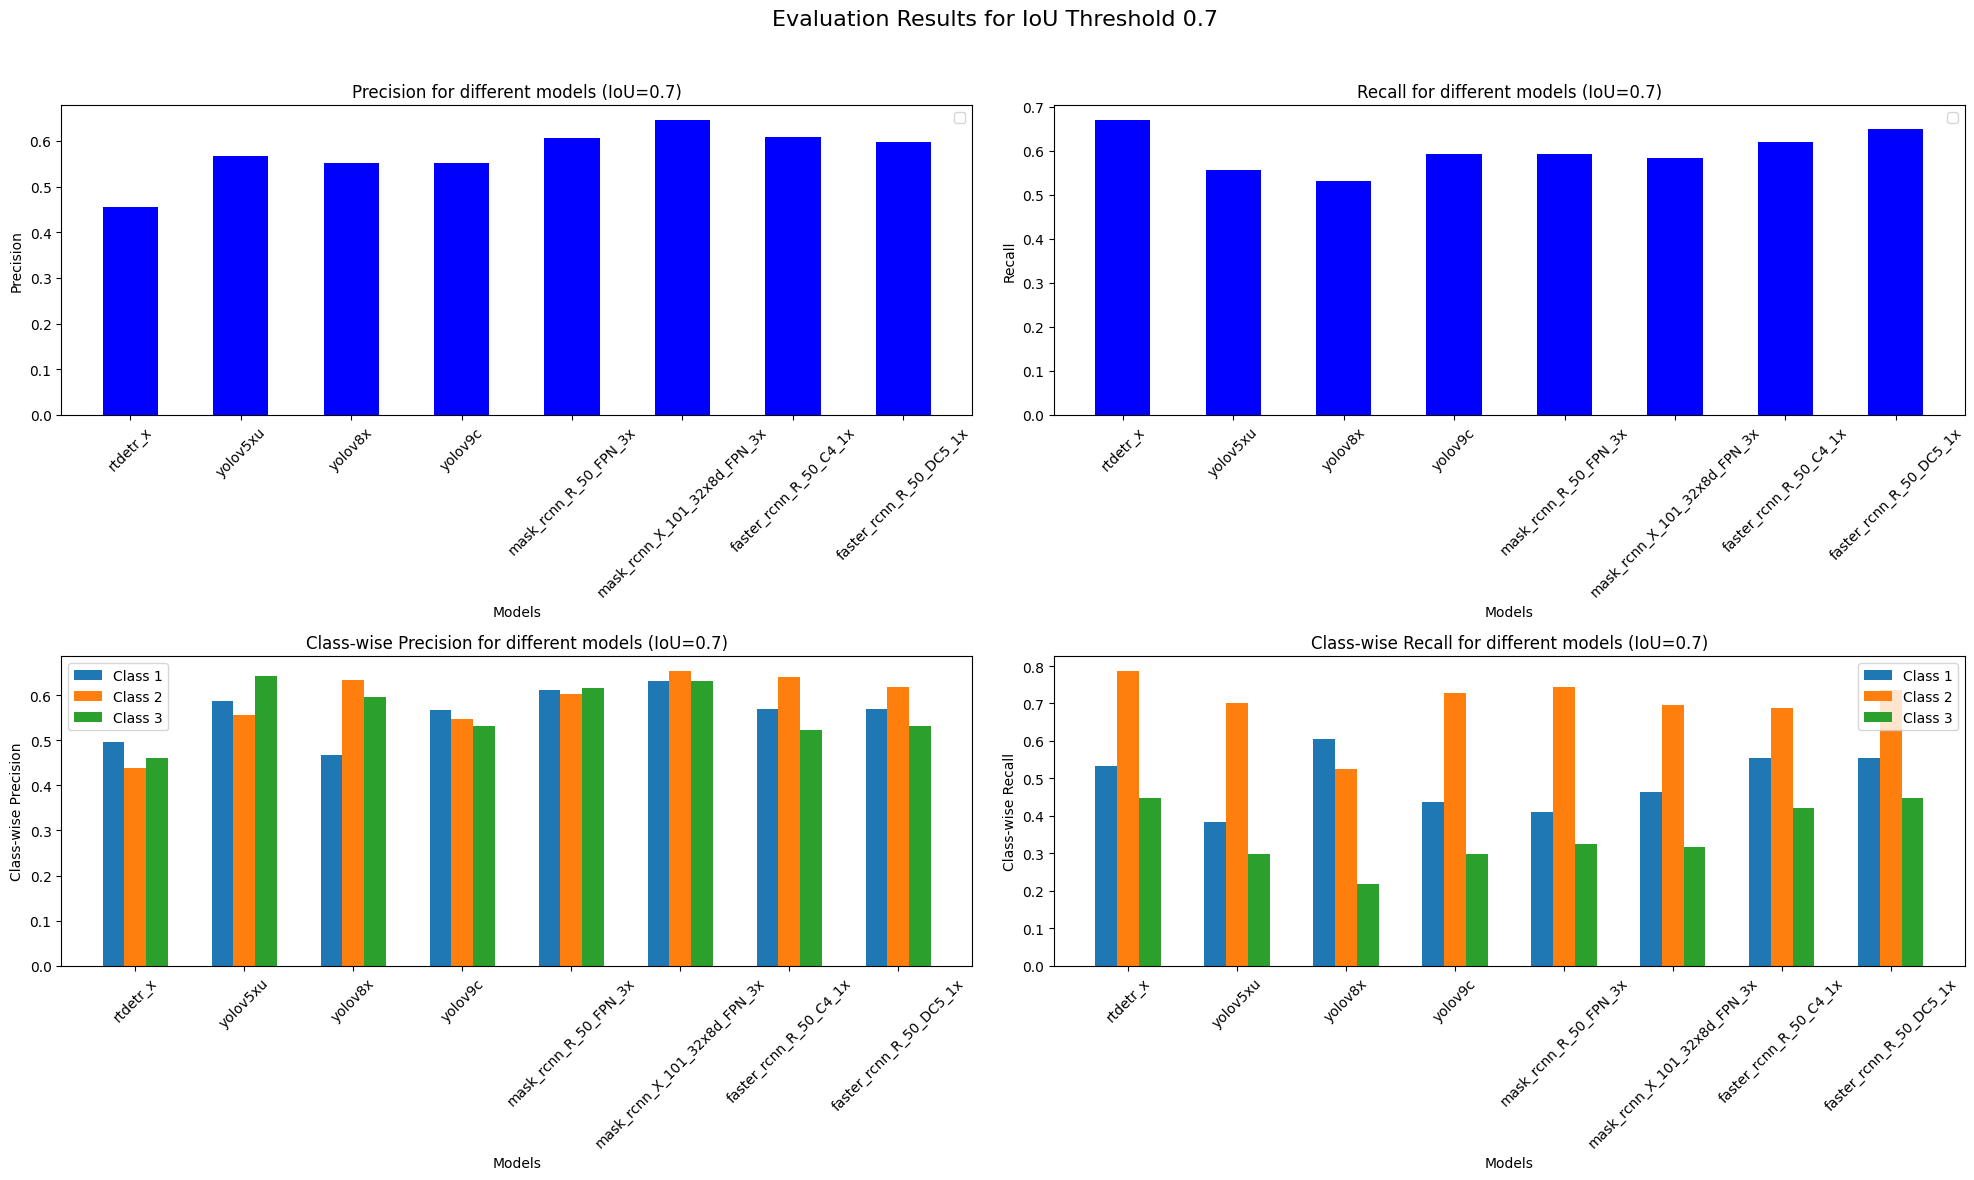

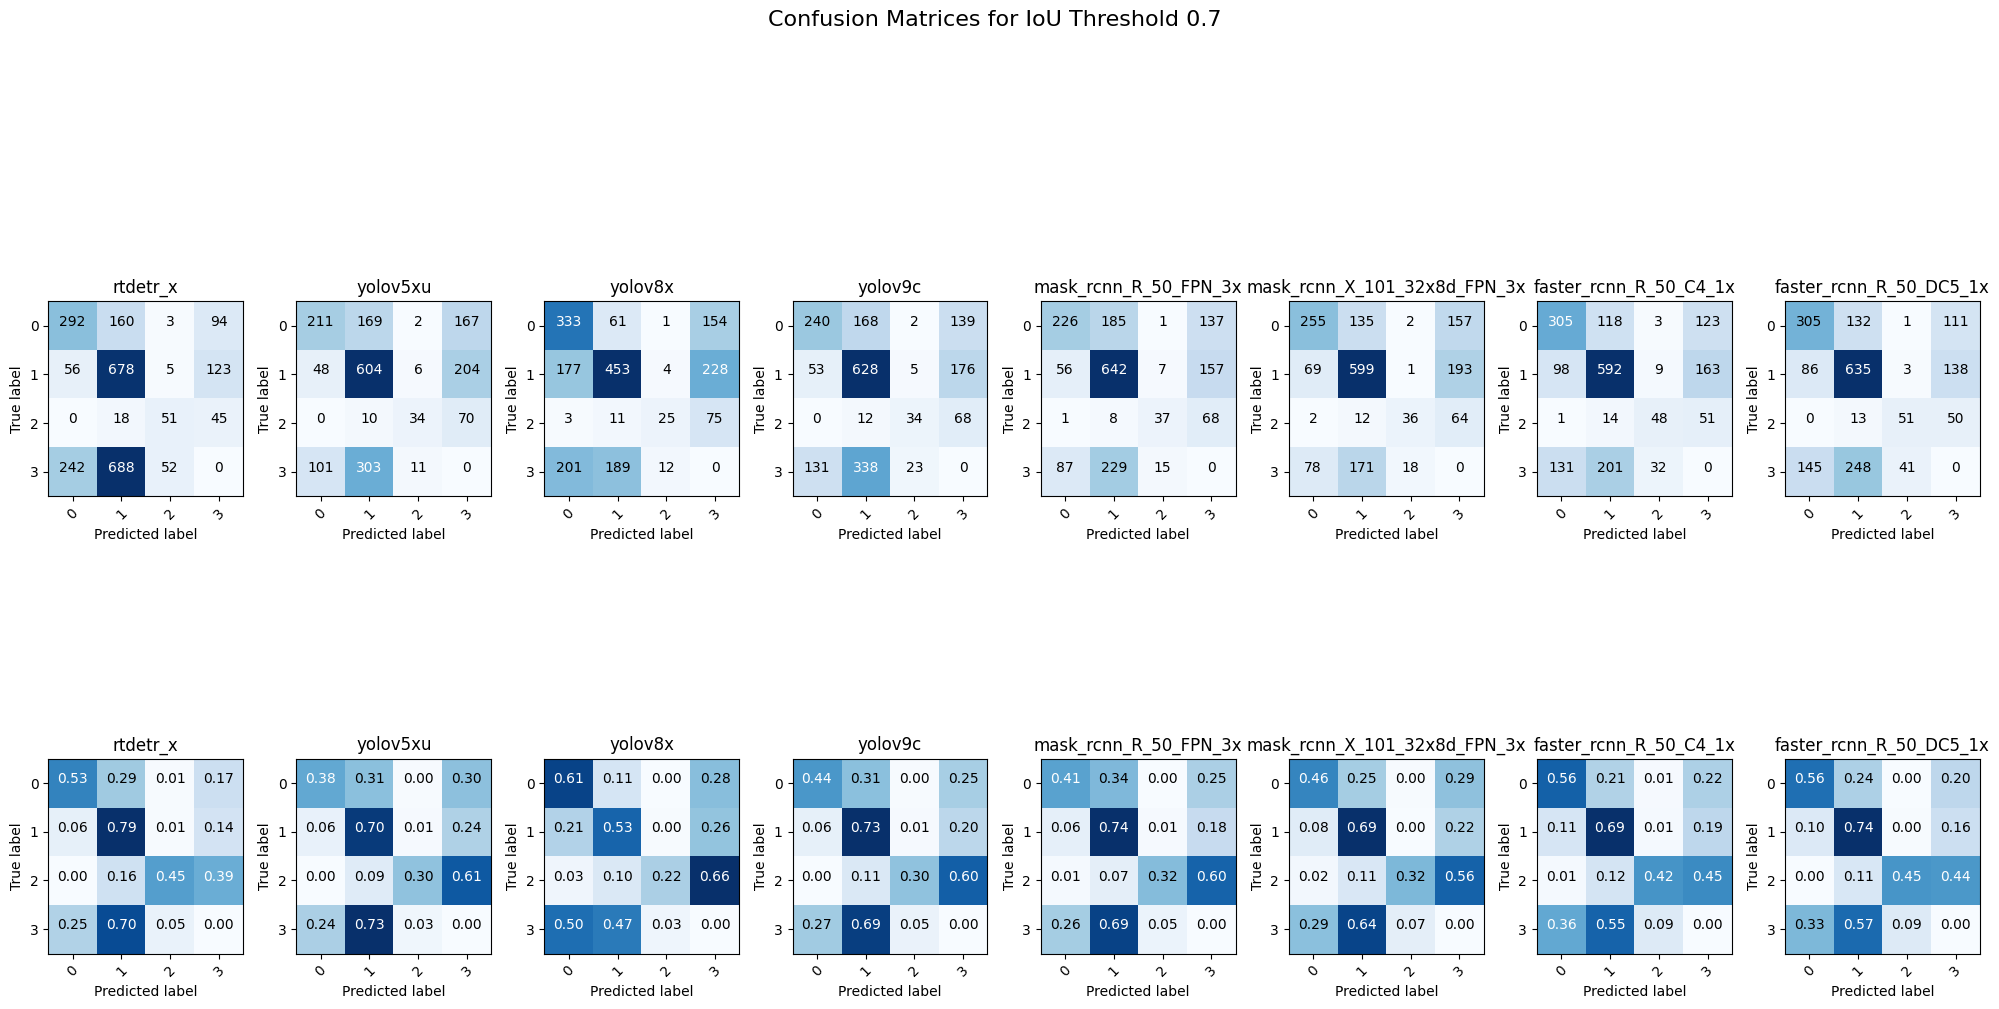

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.75


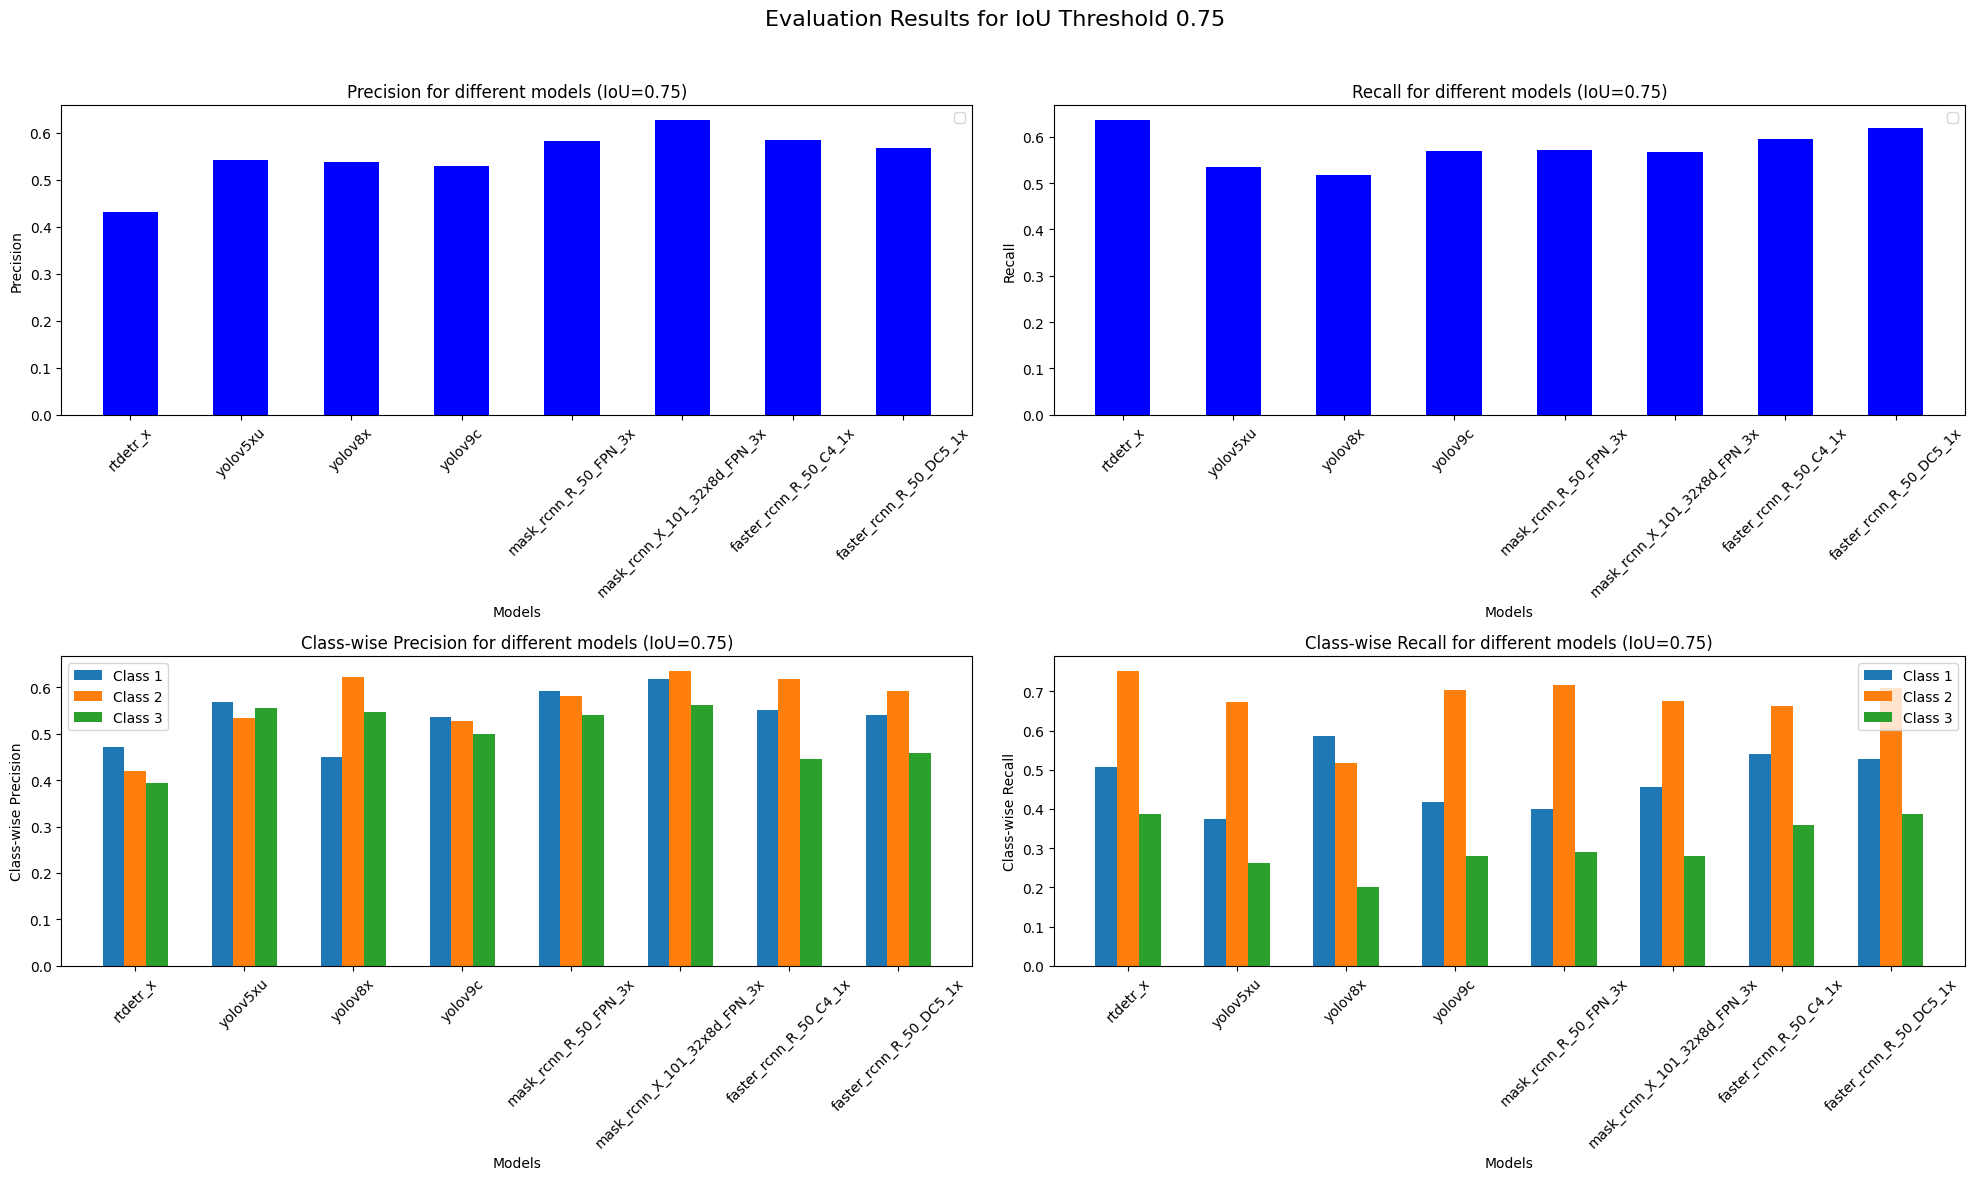

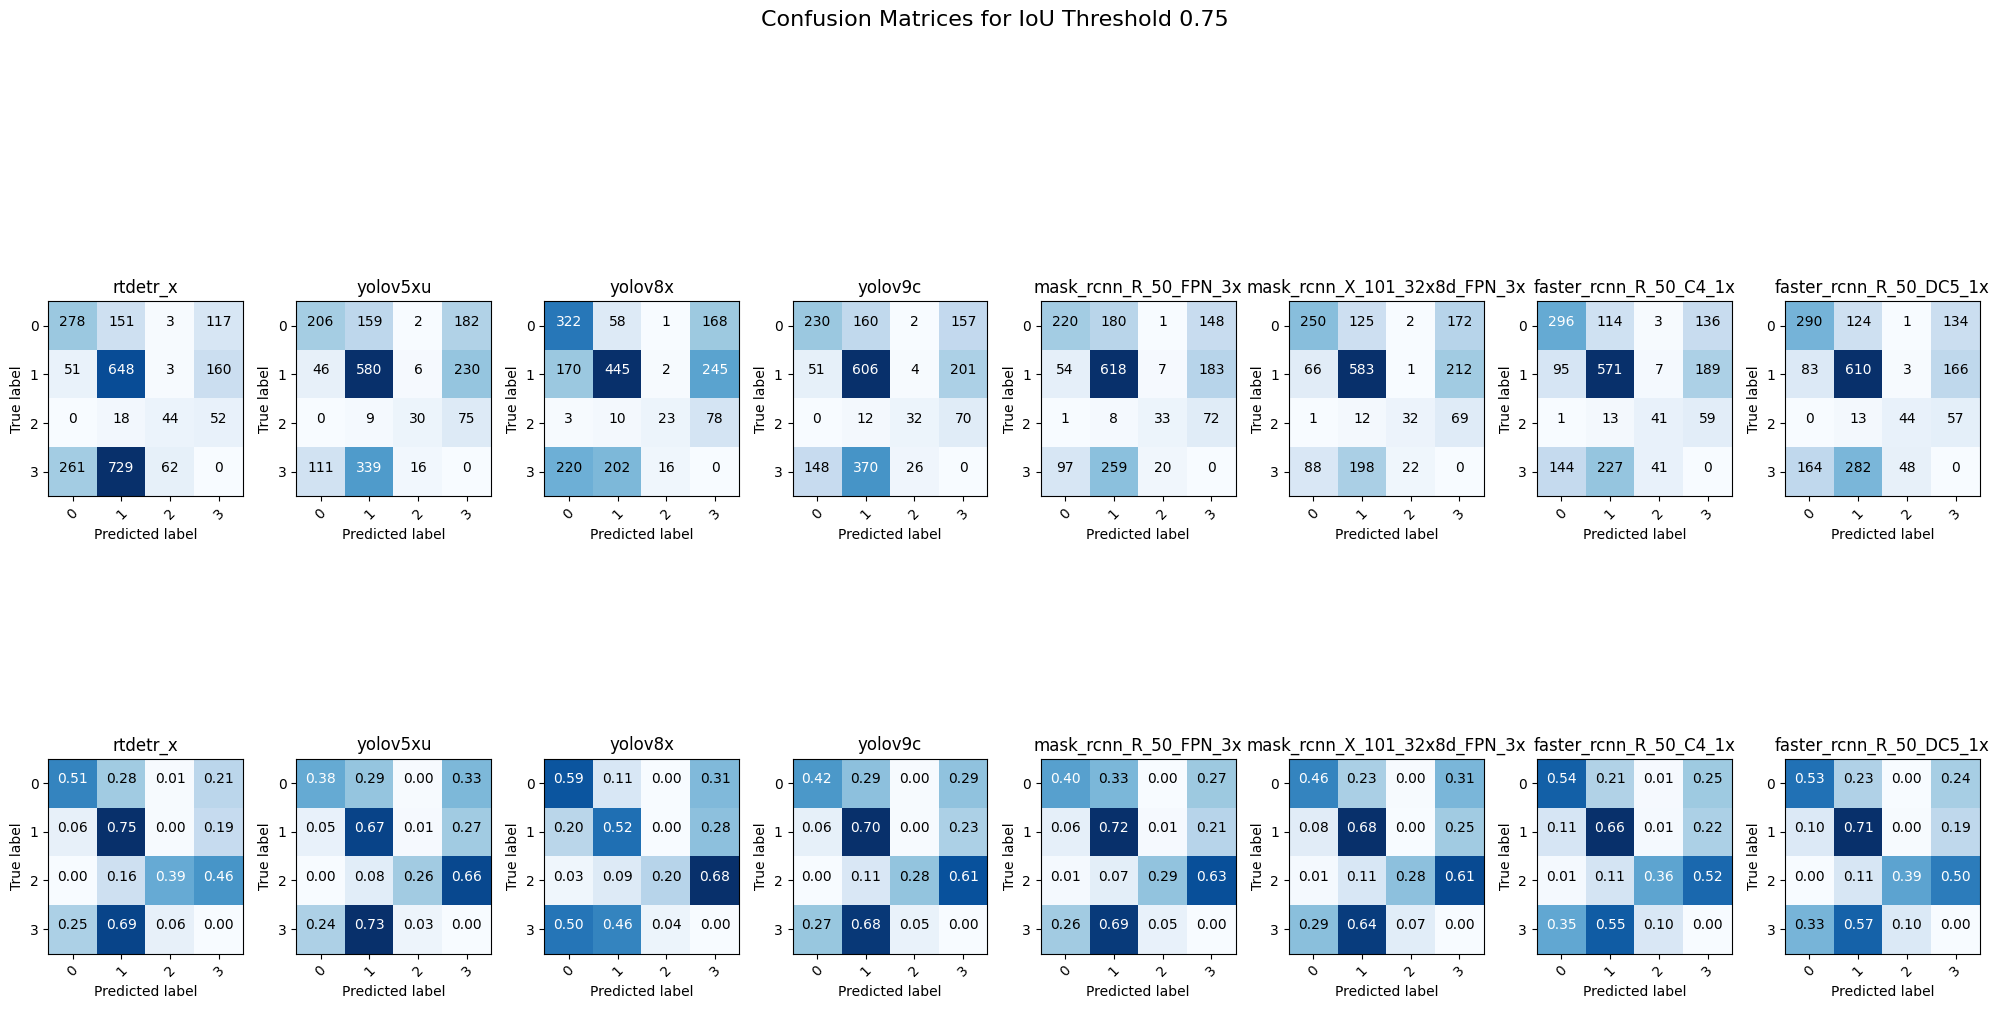

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.8


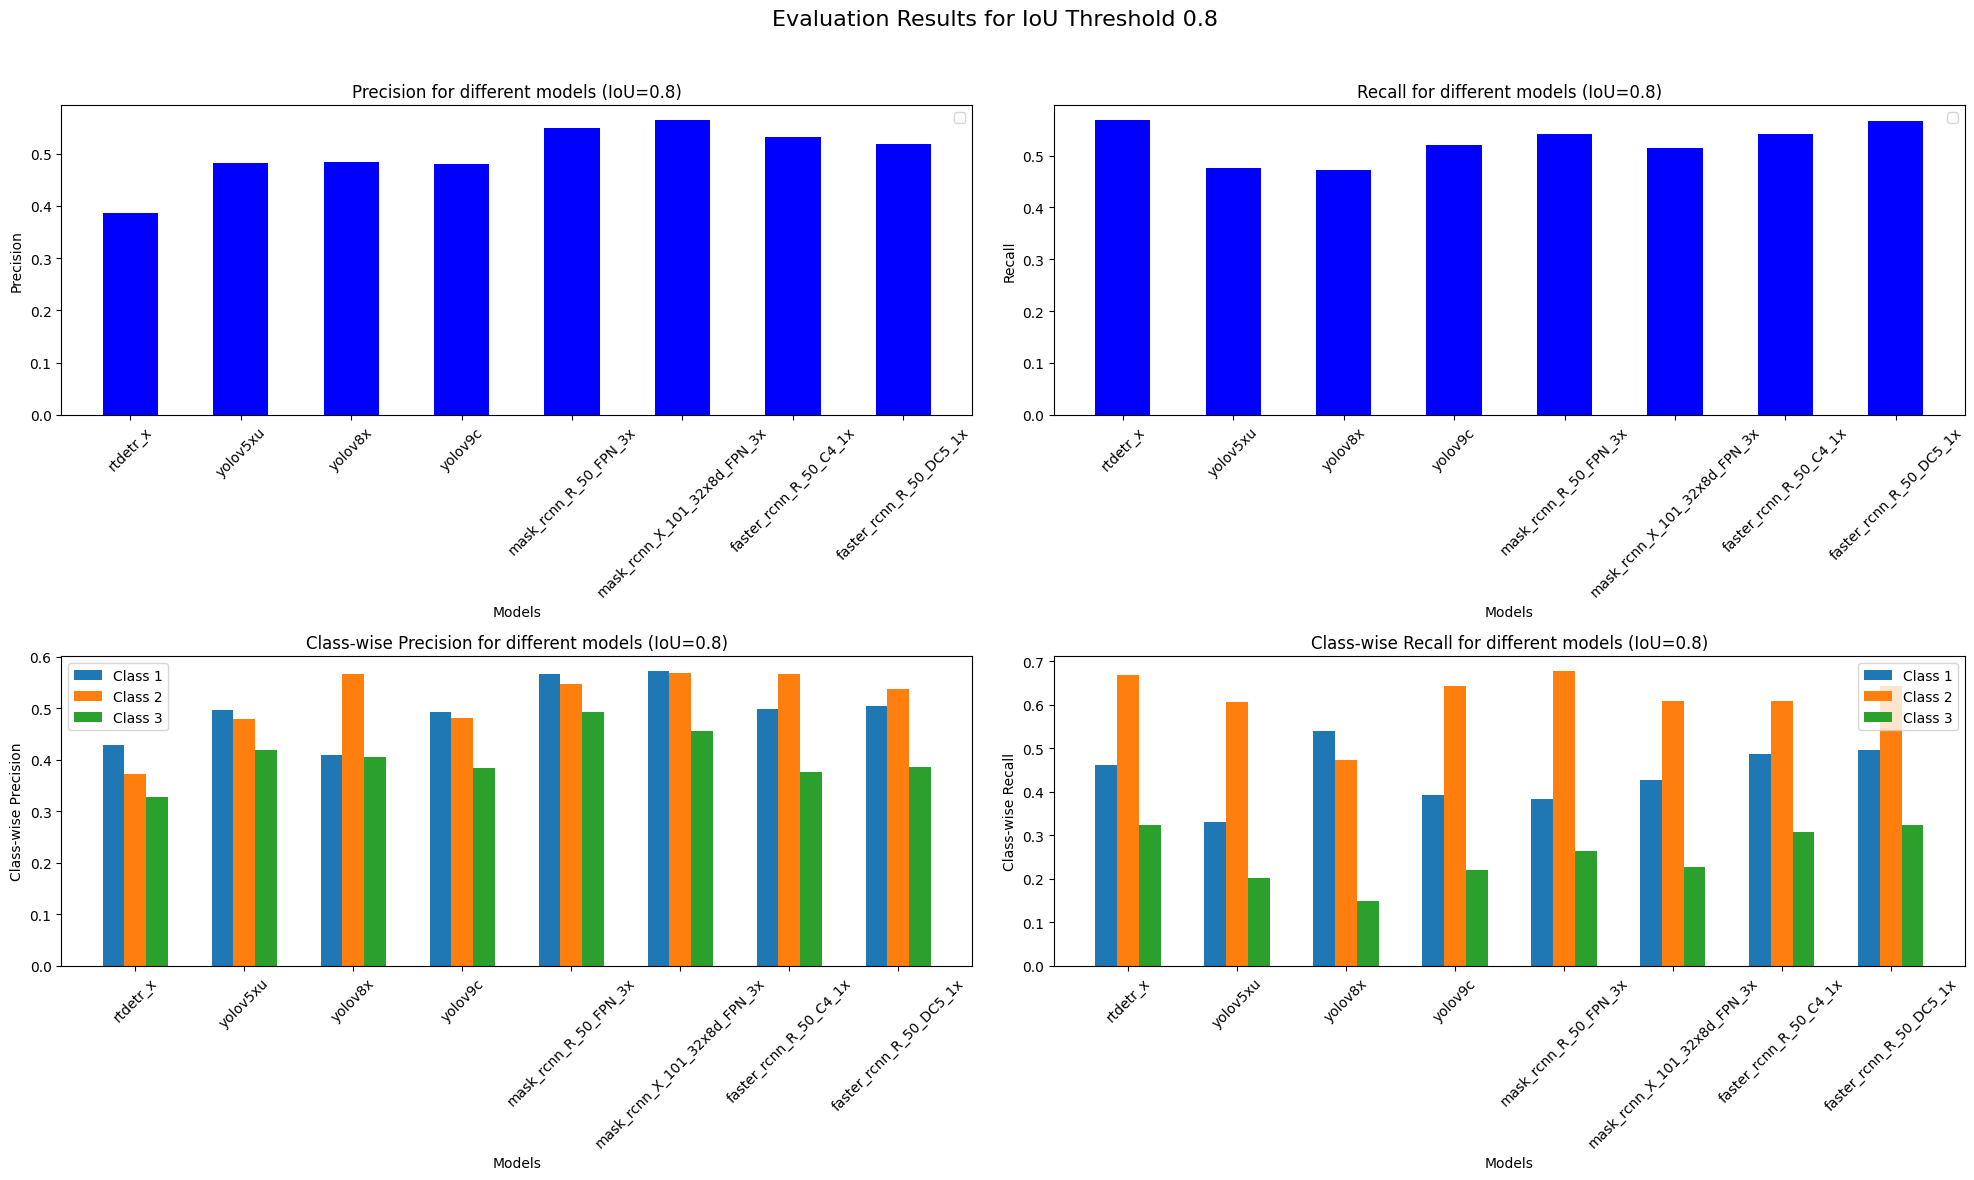

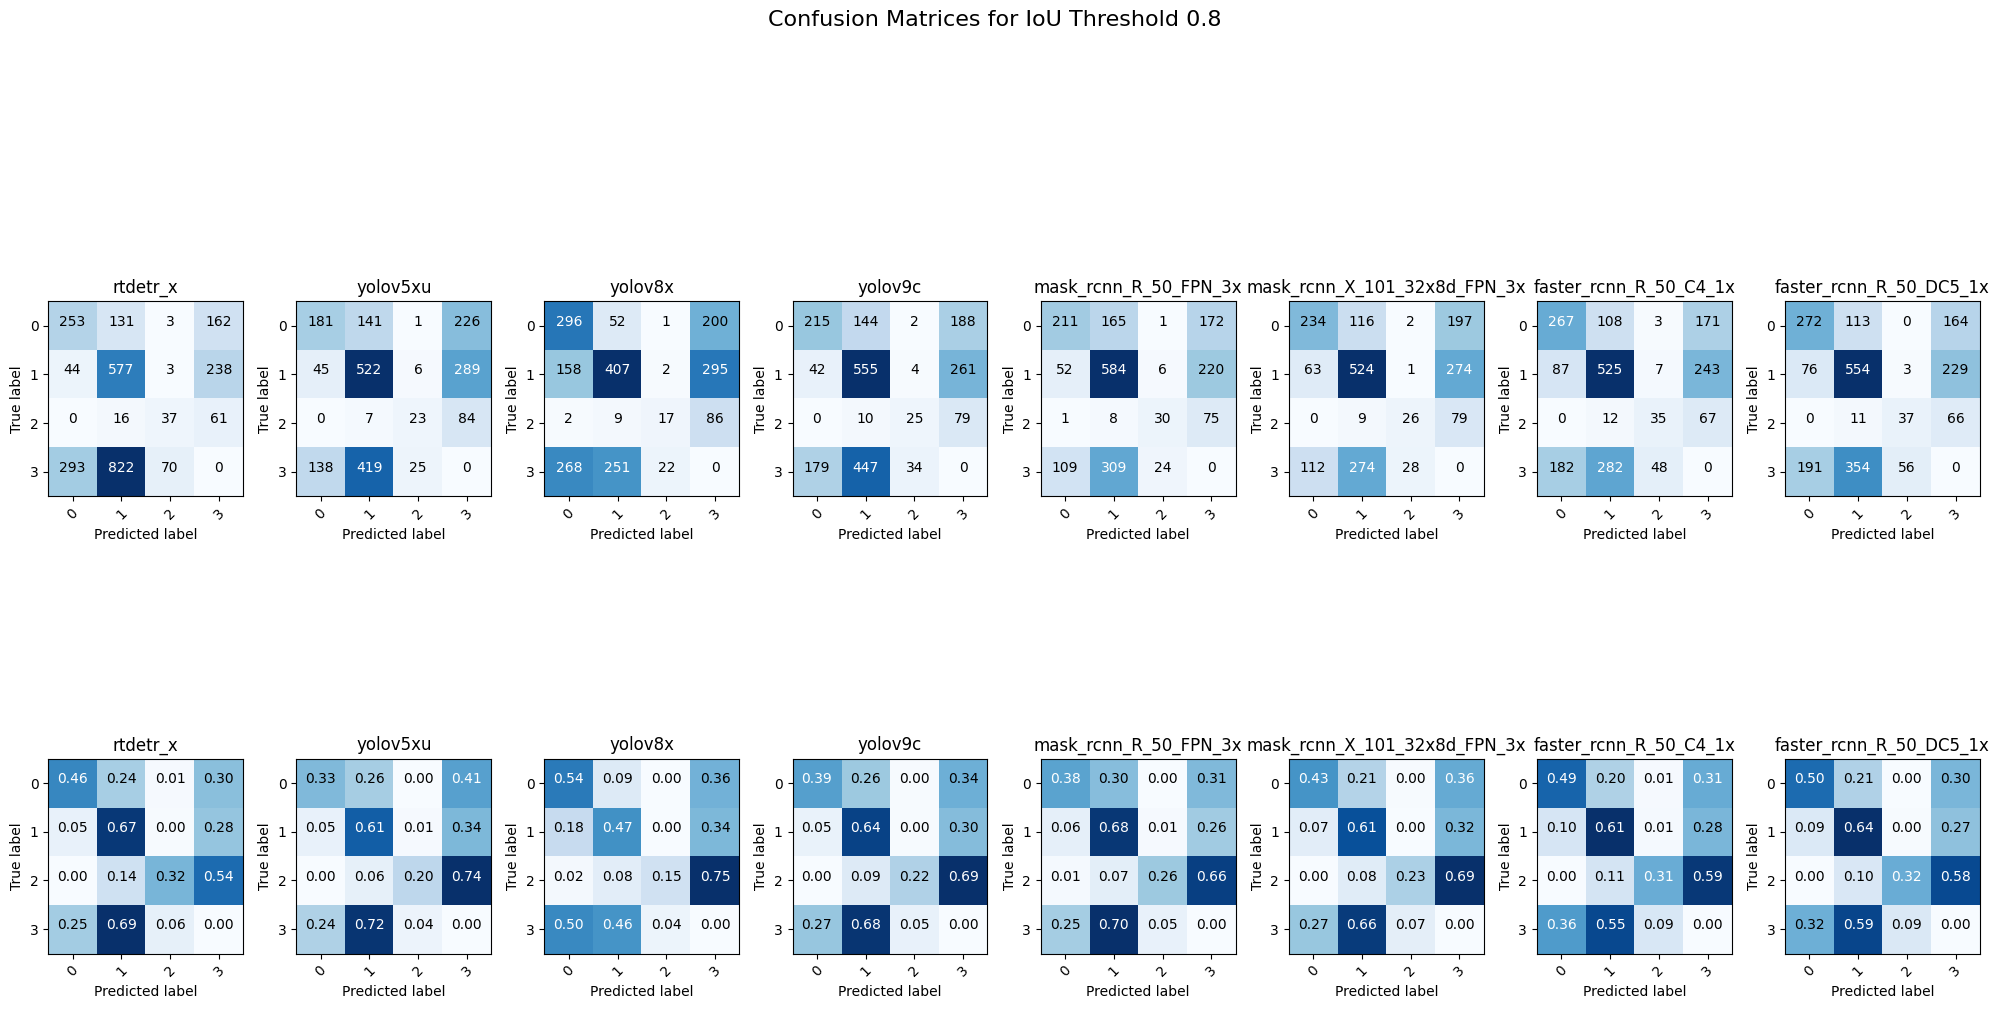

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.85


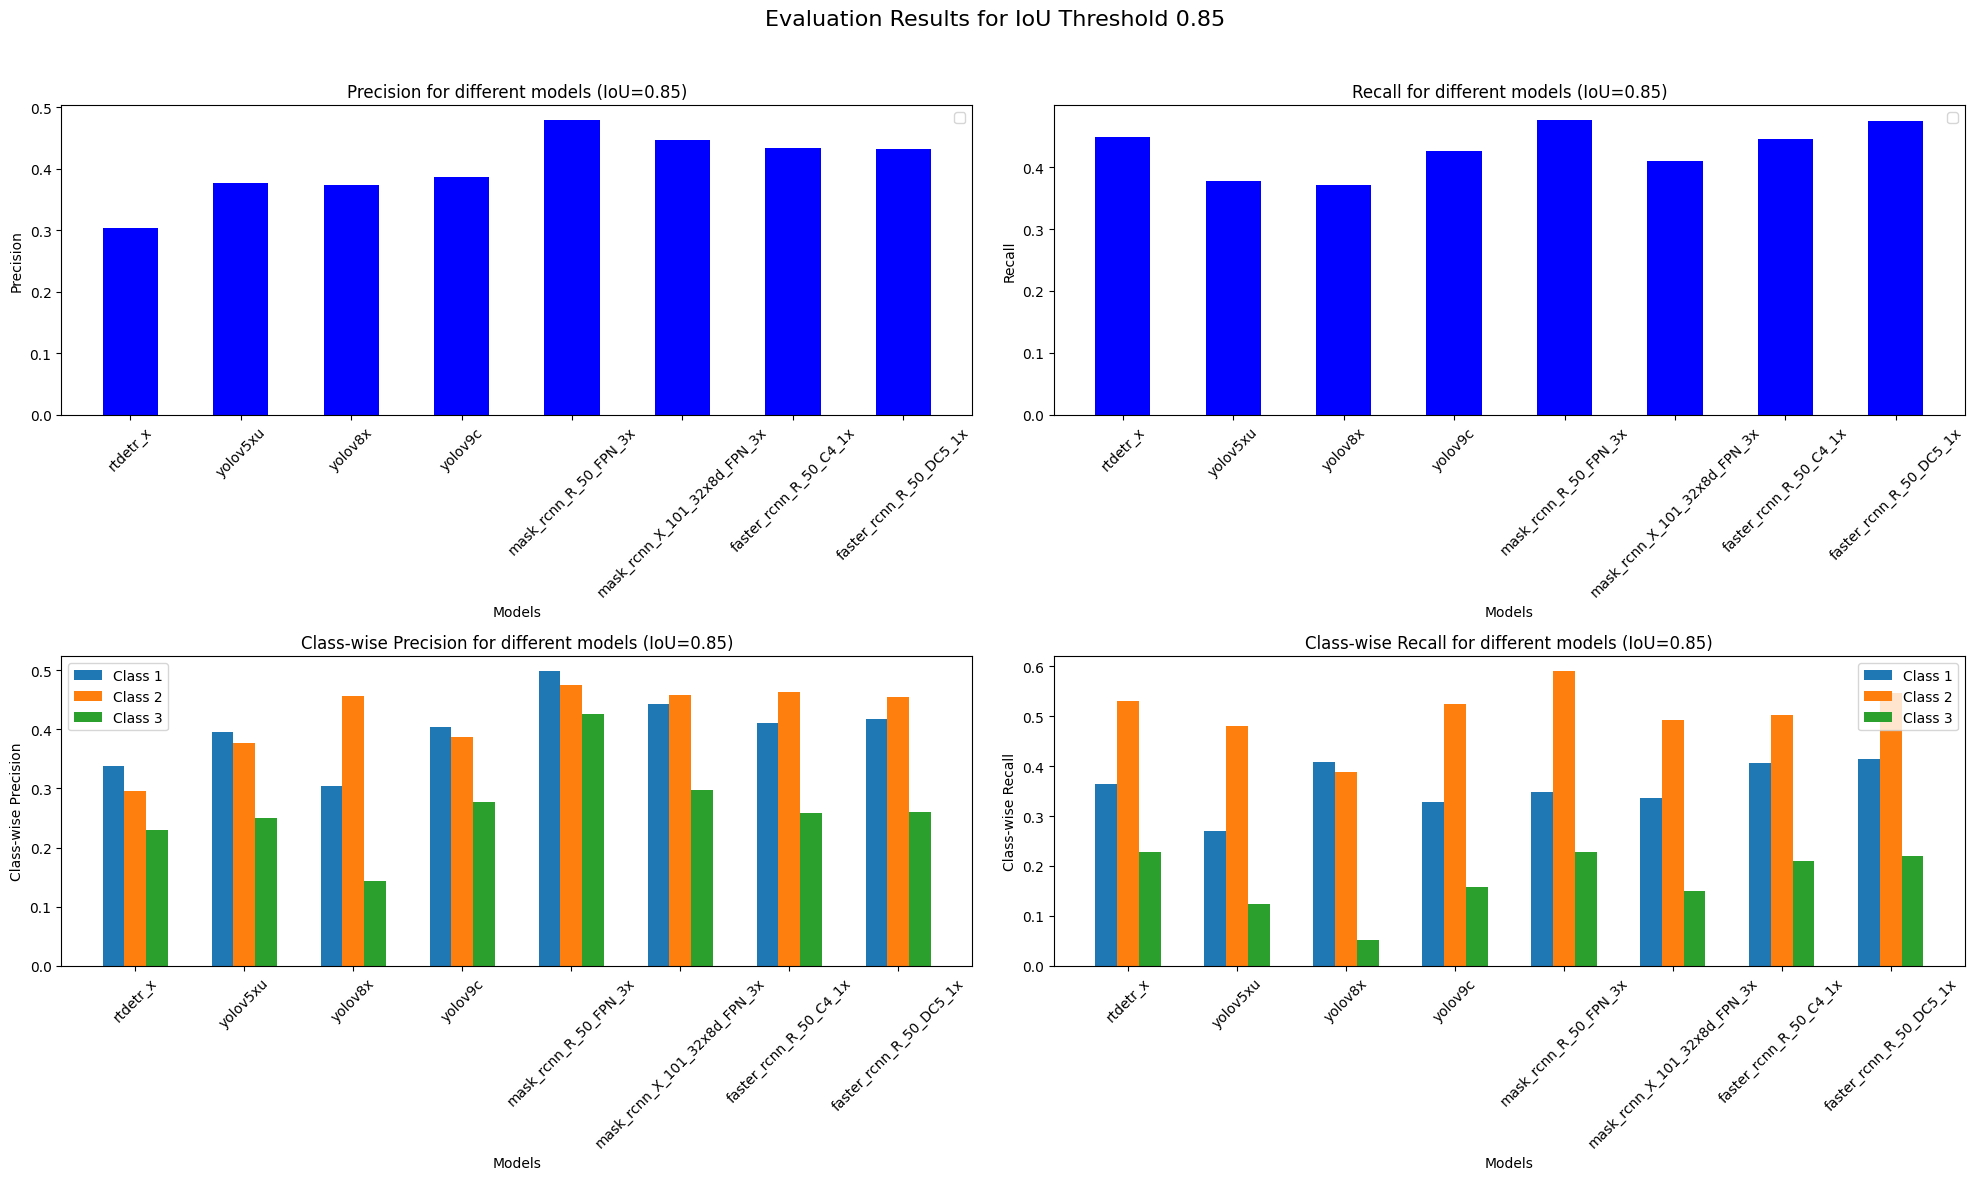

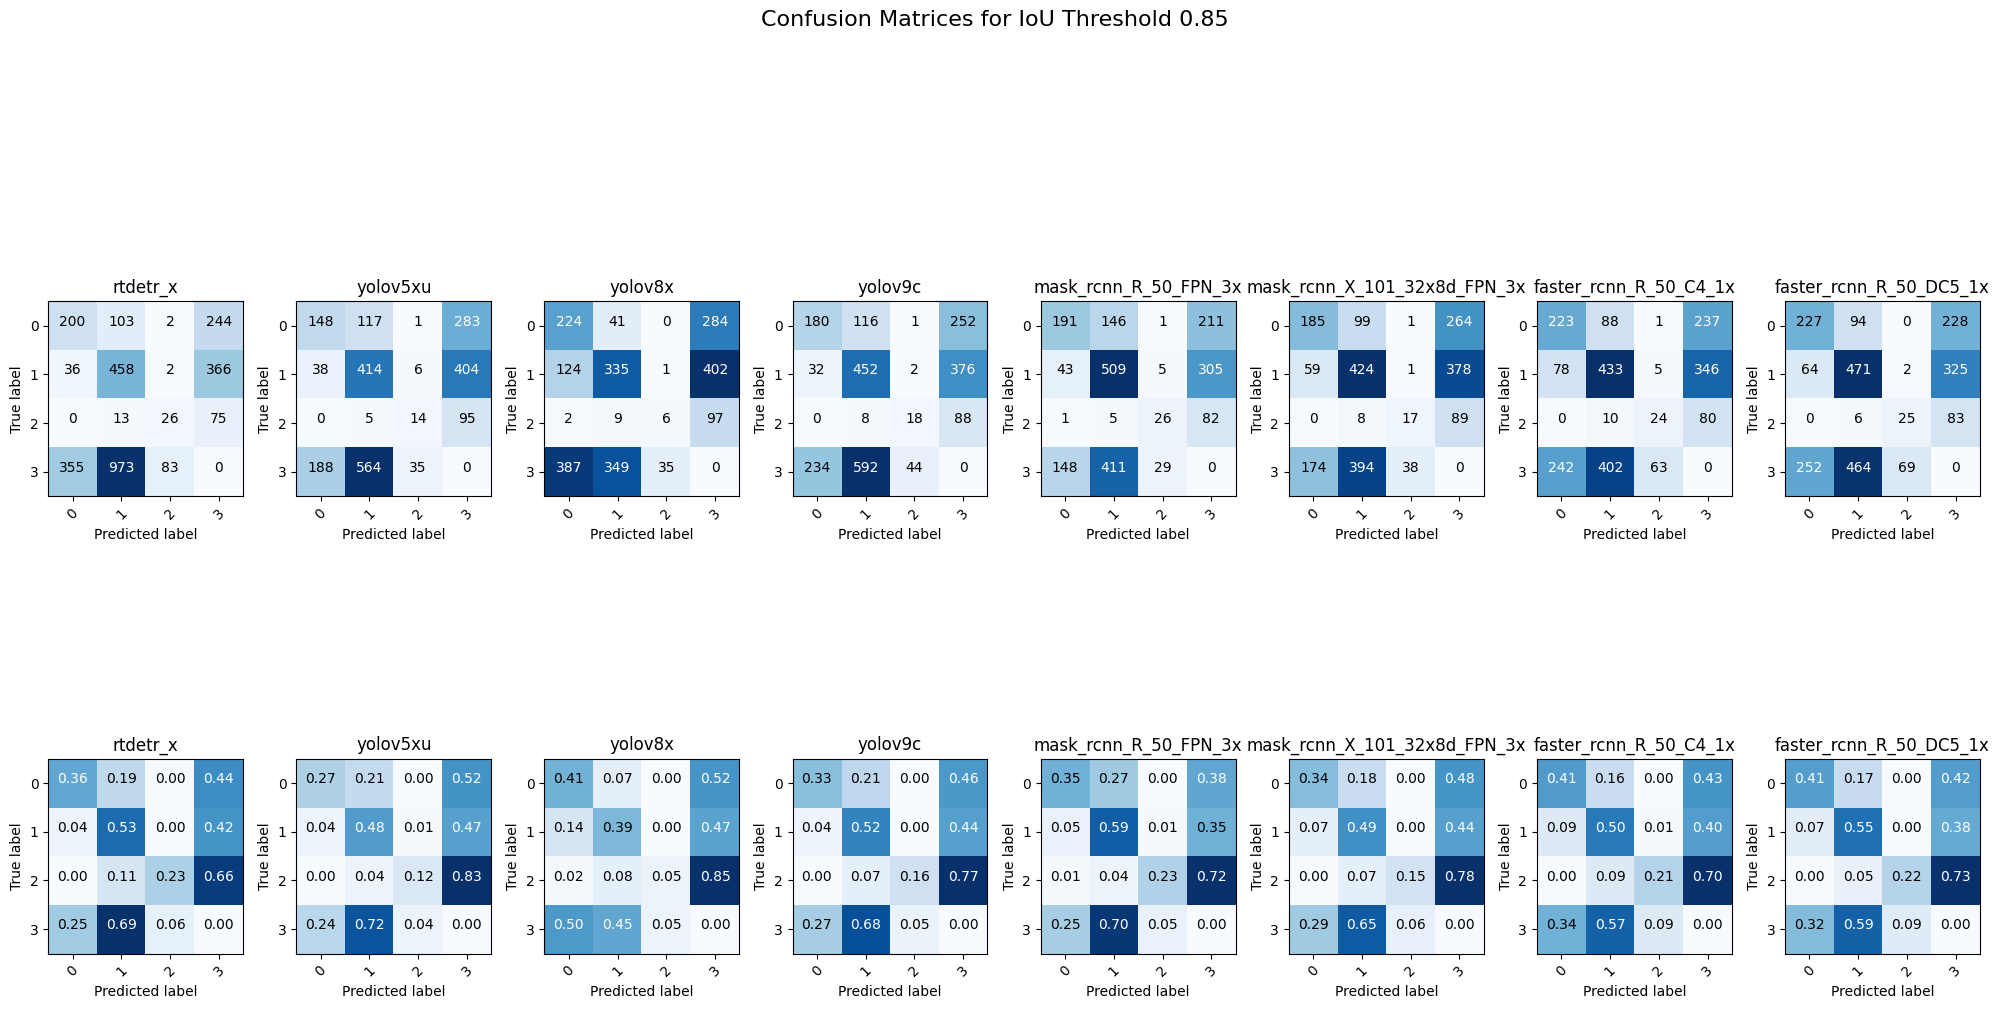

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.9


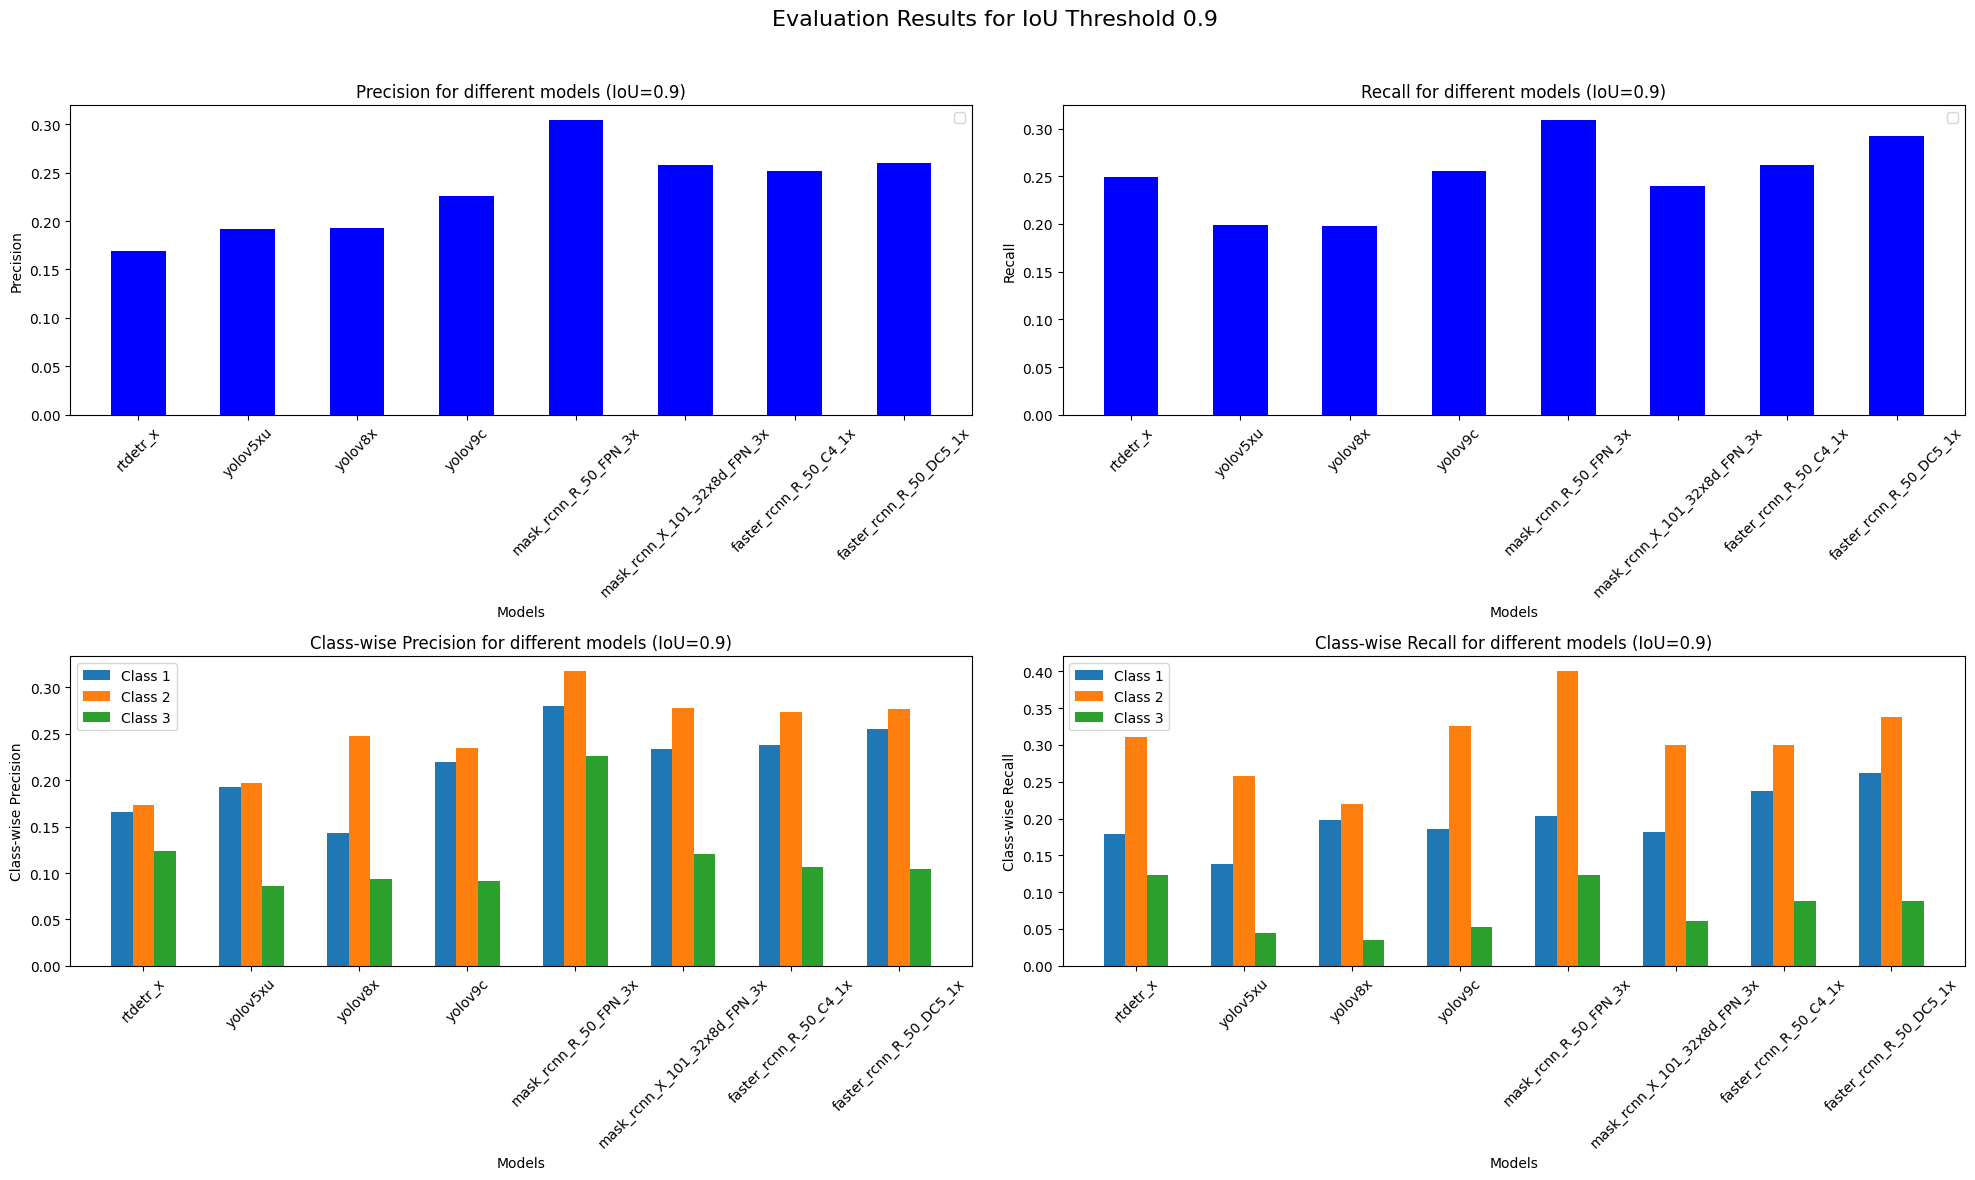

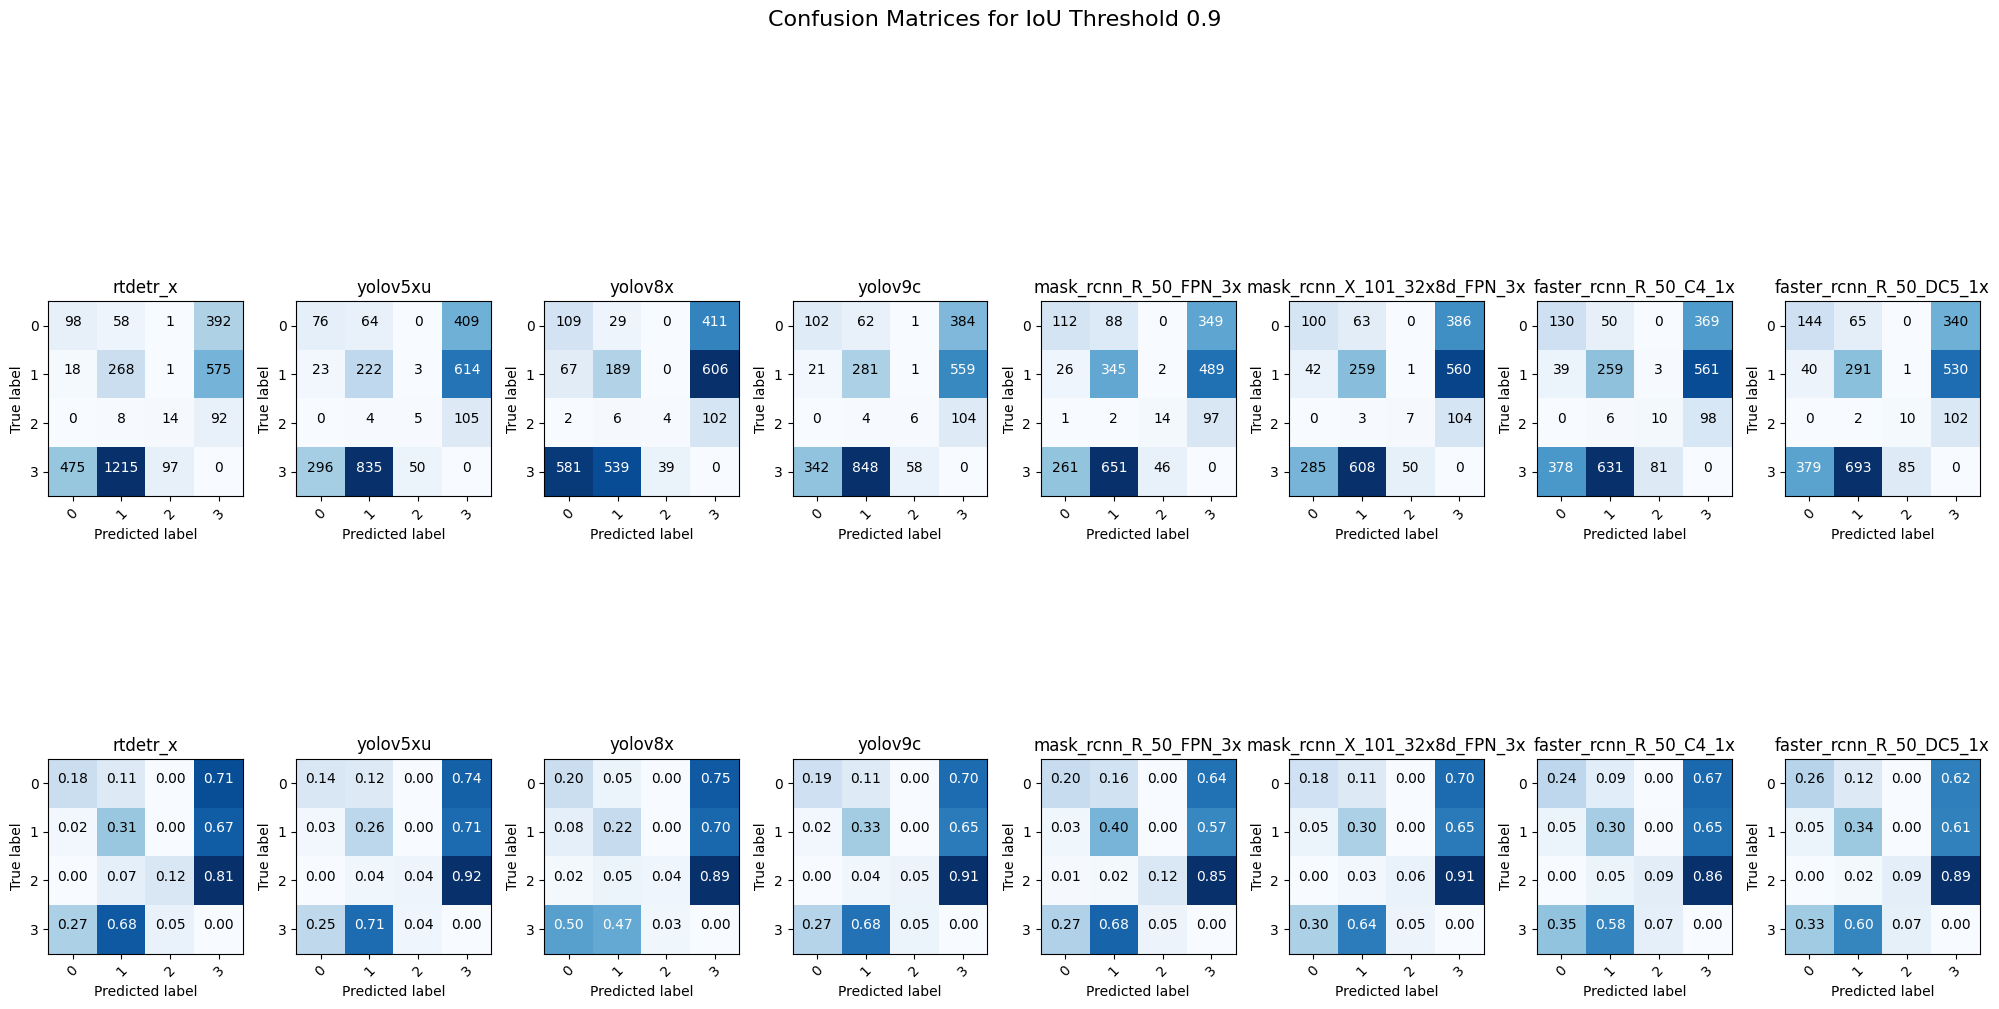

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Results for IoU threshold: 0.95


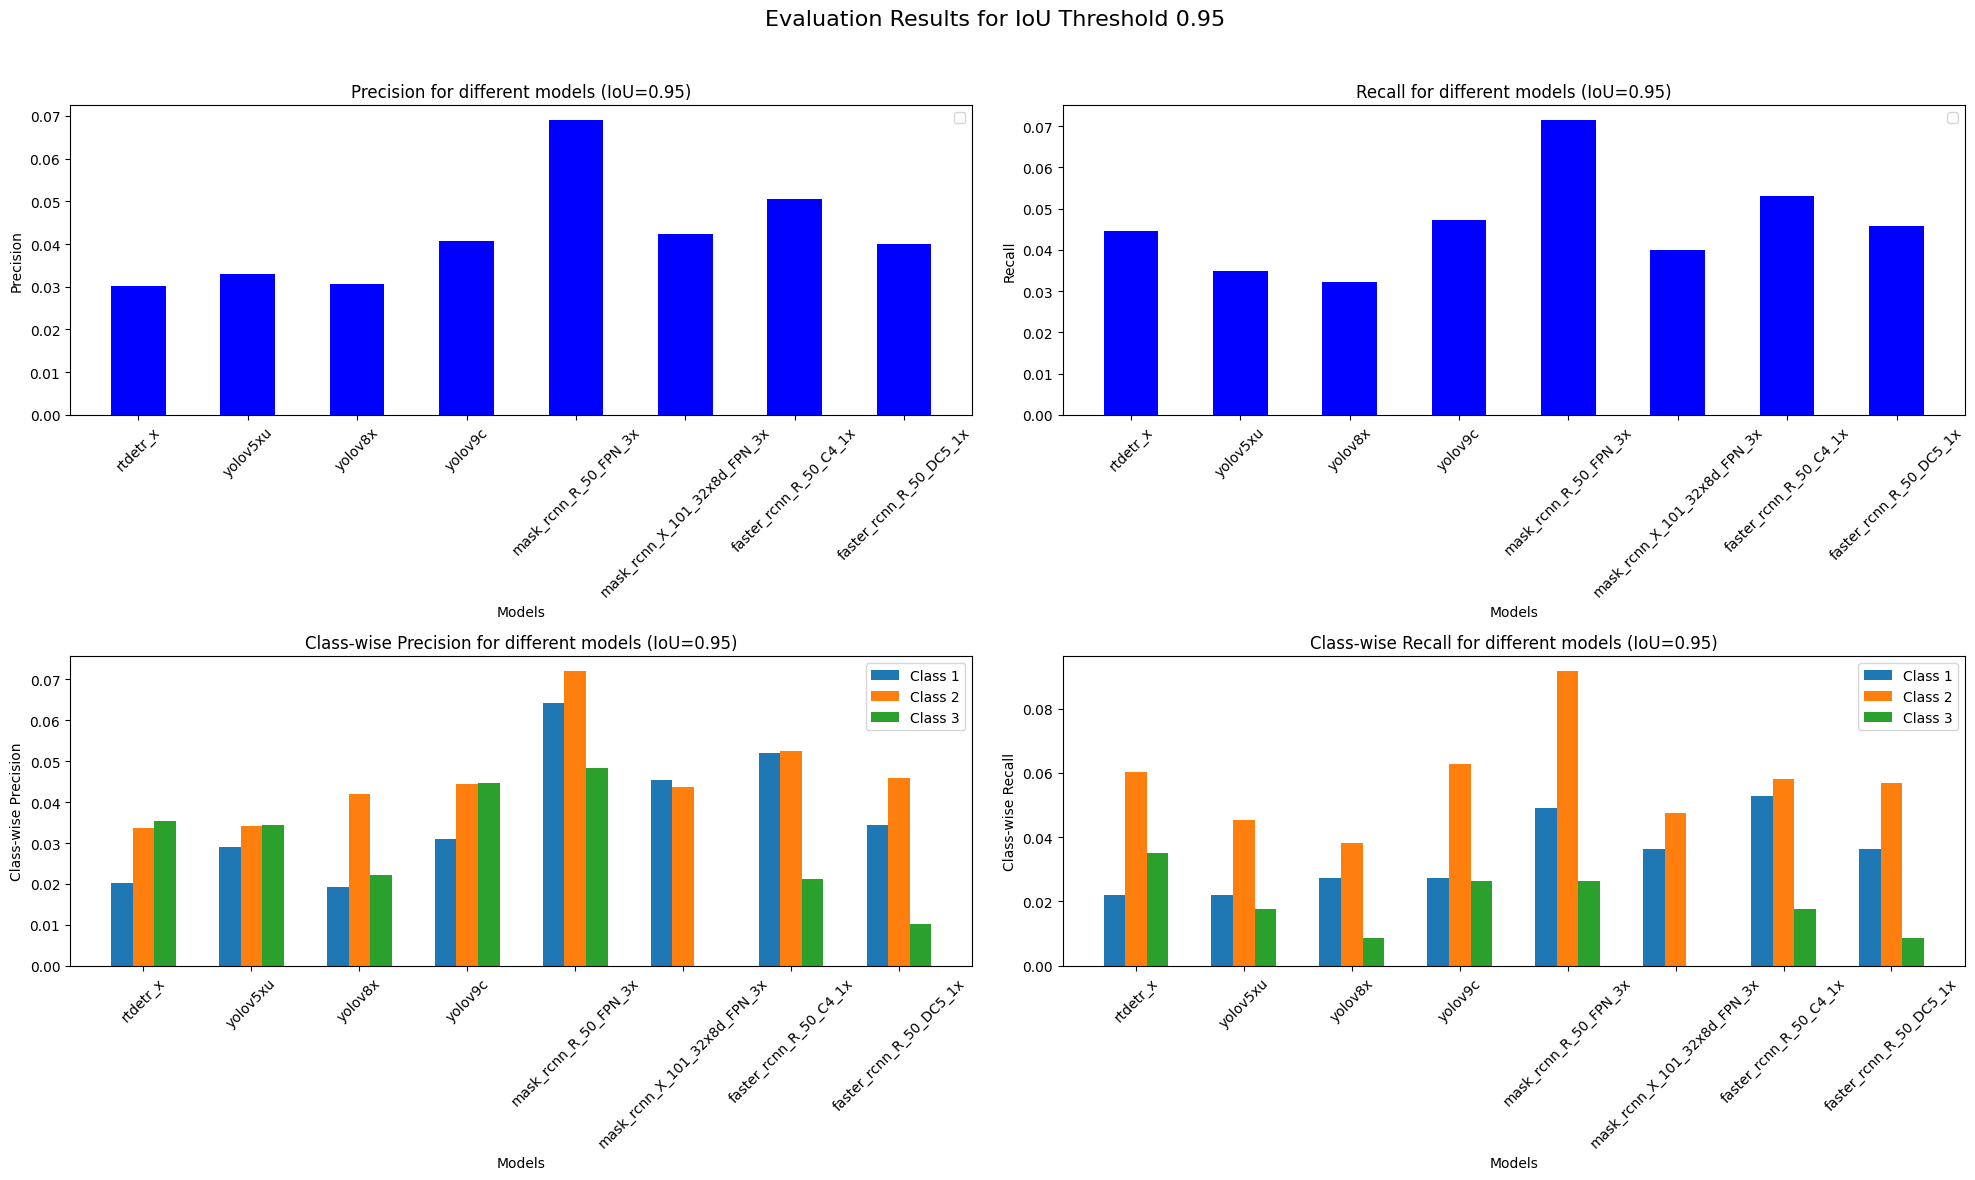

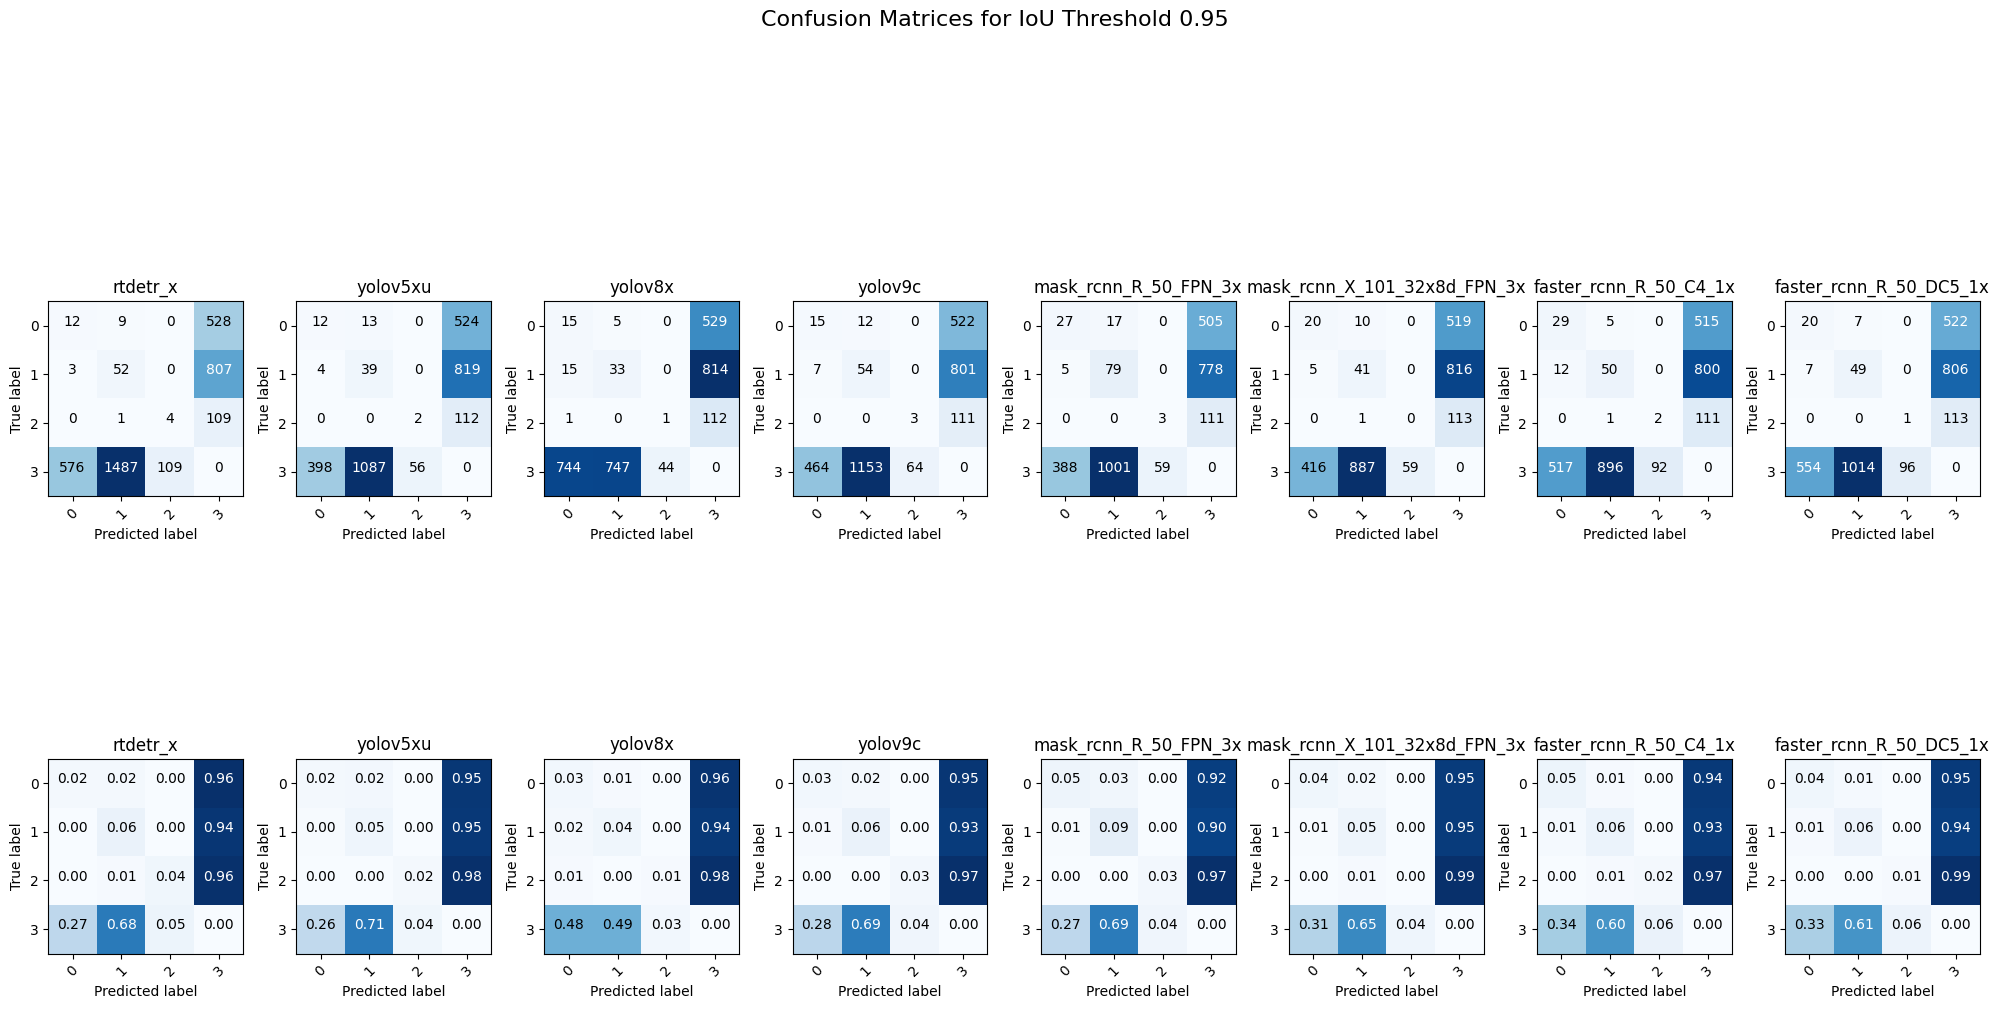

In [14]:
# plot the results for each iou
for iou_threshold, iou_results in results.items():
    iou_threshold = np.round(iou_threshold, 2)
    print(f"Results for IoU threshold: {iou_threshold}")
    plot_evaluation_results(iou_results, iou_threshold)